# W207 Final Project:  Forest Cover Type Prediction
### Brandon Castaing, TK Truong, Dili Wang, Yaran Zhang
### April 8, 2019
  



## Part 1 - Introduction

### Problem Description
Identifying tree species can be vital to the understanding of the ecological system in a forest.   Being able to predict the predominant tree cover types quickly and effectively for large forest areas can assist in the management of resources that serve to maintain and/or expand these areas.

In this problem, we are given cartographic and environmental data from samples of 30 square-meter patches of land in Roosevelt National Forest.  The patches come from 4 different wilderness areas, and each consists of one of 40 different soil types.  Furthermore, we are provided the following data for each patch - distance to hydrology, distance to roadways, distance to fire points, hillshade for 3 times of the day, elevation, aspect and slope. Using the various features of each patch, our objective is to build a machine learning model which can accurately predict the predominant tree cover type of each patch, out of 7 possible classes for the cover type variable. 

Below are the seven tree cover types and the corresponding habitat from some research: 

* **1 - Spruce/Fir** : tolerant to shade and cold, likes humidity and has strong adaptability. Fond of being born on both sides of gullies and valleys. usually in dry and cold in the high latitudes. Soil is acidic and humid.
* **2 - Lodgepole Pine** : tall and slim, growth intensively，like lights and easy to burn, seed will germinate after burning, common in dry area.
* **3 - Ponderosa Pine** ：strong adaptability, can grow normally in sandy soil, loam and stony soil, but not in wet soil
* **4 - Cottonwood/Willow** ：growth sparsely， wind prevention and sand fixation.
* **5 - Aspen** ：grows mostly on hillsides, ridges and valleys, often forming small areas of pure forests or mixed forests with other tree species, resistant to cold, drought and barren soil. Soil is slightly acidic to neutral soil.  suitable for mountain belly drainage good fertile soil. 
* **6 - Douglas-fir** ：grow in mild, humid summer drought area, grow well in the deep, moist and well-drained sandy soil of the north/northeast/east slope, likes light but is resistant to lateral shading.
* **7 - Krummholz** ：tolerant to wind power and the accumulation of snow in winter and spring, deformed, bent or dwarfed to form a shrubby shape, forming barren soil resistance, strong sprouting force, adapting to high air temperature and strong wind.

### Feature Interpretation
Combining the forest habitat and the ecological concept of provided features, we get a basic understanding of the potential impact of each feature on forest type, and further identify below 

**KEY FEATURES**:
* **Elevation** : related to the temperature and which forest types can adapt to it.
* **Hydrology(two measurements)**: reflects the supply of water and which forest types can adapt to it.
* **Hillshade(three measurements)** : related the duration and intensity of sunlight and which forest types can adapt to it. Sunlight itself is hard to measure.
* **Horizontal_Distance_To_Fire_Points** : one theory we have is that it reflects the difficulty of self-ignition and combustibility of the tree which partially determined by the texture and constituent of the tree. Another theory is some type of seed needs fire to germinate which also reflects forest type to some extent. These two theories have completely different impact but both imply a high correlation to the forest type. 
* **Soil_type**: reflects soil’s pH value, and soil particle size/type which affects soil’s ability to hold water and mineral elements types in the soil.

For the rest of the factors, listed below, we suspect that they are either highly correlated with one of the above factors or not as relevant to cover type, which we will explore in our EDA.
* **Aspect** : looks like related to both elevation and Hillshade. 
* **Slope** : looks like related to both elevation and Hillshade/Aspect. 
* **Wilderness_Area** : there are four geographic areas which to some extent reflects different ecological features(i.e. the above features) and therefore different forest type. Scatter plotter is needed to see patterns.
* **Horizontal_Distance_To_Roadways** : we think roadway is usually built on plain or the safest area with the shortest route, it somewhat reflects landform, but the distance from forest doesn't matter or say could vary a lot. We will do correlation check to see its statistical significance of correlations with the forest type and other features. 


## Part 2 - Preliminary Exploratory Data Analysis

In [14]:
### Load all packages needed
%matplotlib inline
import sys
print(sys.version)
import numpy as np
print(np.__version__)
import pandas as pd
print(pd.__version__)
import matplotlib.pyplot as plt
import csv
from matplotlib.ticker import MultipleLocator
from matplotlib import cm as cm
import warnings
import math
warnings.filterwarnings(action='ignore')  # see warining once: warnings.filterwarnings('once')
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import copy
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
import datetime
from sklearn import metrics
import time

3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
1.15.4
0.23.4


### 1. Data Loading and Inspection
We load the 'train_data' set and split it into three portions: train data, dev data and test data. 

In [2]:
### Load CSV into Dataframe
train = pd.read_csv('train.csv', index_col = 0)

### Split the data into train, dev, test with a 80-10-10 ratio
np.random.seed(0) # random seed so we get the same shuffle

X = train.drop('Cover_Type', axis = 1)
Y = train['Cover_Type']

shuffle = np.random.permutation(np.arange(X.shape[0])) # shuffle the data
X, Y = X.iloc[shuffle], Y.iloc[shuffle]

train_data, train_labels = X[:12096], Y[:12096]        # the train set
dev_data, dev_labels = X[12096:13608], Y[12096:13608]  # the dev set
test_data, test_labels = X[13608:], Y[13608:]          # the test set
print(train_data.shape, train_labels.shape)
print(dev_data.shape, dev_labels.shape)
print(test_data.shape, test_labels.shape)
print("Training Label Distribution:\n", train_labels.groupby(train_labels).size())  # check label distribution

(12096, 54) (12096,)
(1512, 54) (1512,)
(1512, 54) (1512,)
Training Label Distribution:
 Cover_Type
1    1724
2    1726
3    1737
4    1705
5    1735
6    1732
7    1737
Name: Cover_Type, dtype: int64


### 2. Exploratory Data Analysis

In [3]:
#Deep copy of train_data specifically for EDA. 
#This is to prevent EDA transformations from inadvertently affecting train_data in anyway.
train_data_EDA = train_data.copy(deep = True)

#join with train data with labels for key scatter plots:
train_data_EDA = train_data_EDA.join(train_labels)

**General Sanity Check and Data Cleaning**

Considering the nature/concept of each feature columns, we perform below sanity checks on some columns to detect unqualified data(i.e. suspicious data errors) and then remove the detected violations from the dataset before further analysis. 

According to the check we performed below (listed here), there is **NO qualified data detected**, so no records will be removed from the train data set at this point.
* Records with NaN in any columns should be removed
* Records with Wilderness_Area 1~4 containing more or less than one 1 should be removed
* Records with Soil_Type 1~40  containing more or less than one 1 should be removed

In [4]:
### Check 1: if any NaN value exist
print( "Number of Cells with NaN in the Train_data set:", train_data_EDA.isnull().sum().sum())


### Check 2: Wilderness_Area 1~4 on each row should consisten one 1 and three 0 values (i.e. sum=1)
train_data_EDA['Wilderness_Area_Total'] = train_data_EDA['Wilderness_Area1']+train_data_EDA['Wilderness_Area2']+train_data_EDA['Wilderness_Area3']+train_data_EDA['Wilderness_Area4']
print("Wilderness_Area check:", len(train_data_EDA['Wilderness_Area_Total'][train_data_EDA.Wilderness_Area_Total == 1]), "out of total", len(train_data_EDA['Wilderness_Area_Total']),"records with sum-up equal to 1")


### Check 3: Soil_type_total 1~40 on each row should consisten one 1 and three 0 values (i.e. sum=1)
train_data_EDA['Soil_Type_Total'] =  0
train_data_EDA['Count'] = 1
for i in range(1, 41):
    column_name = "Soil_Type" + str(i)
    train_data_EDA['Soil_Type_Total'] = train_data_EDA['Soil_Type_Total'] + train_data_EDA[column_name]
print("Soil_Type check:", len(train_data_EDA['Soil_Type_Total'][train_data_EDA.Soil_Type_Total == 1]), "out of total", len(train_data_EDA['Soil_Type_Total']),"records with sum-up equal to 1")
 

Number of Cells with NaN in the Train_data set: 0
Wilderness_Area check: 12096 out of total 12096 records with sum-up equal to 1
Soil_Type check: 12096 out of total 12096 records with sum-up equal to 1


**Binary to Multi-Categorical Data Transformation and Inspection**

In order to examine the distribution of Wilderness Area and the soil types, we created categorical columns to create histograms. For the training data, we noticed that Soil_Type10 was the most common by far. However, there were quite a few soil types that have lower frequency counts--something to keep in mind with feature selection in our modeling. In examining soil types by cover type, we noticed that some soil types were more common with certain cover types. For example, cover type 7 tended to have Soil_Types 38-40. However, there were some where it is not as delineated as with Soil_Type10, which had high frequency with both cover types 3 and 6, or Soil_Type29, which had high frequency with both cover types 1 and 2. 

For the Wilderness Areas, we noticed that Wilderness_Area2 is much more underrepresented than the other three areas, with Wilderness_Area3 being the most common.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x109d982e8>,
      dtype=object)

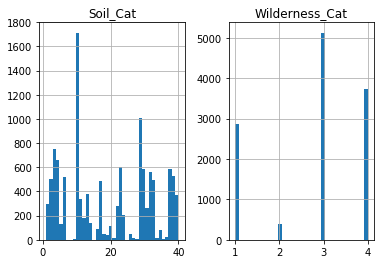

In [5]:
### Create categorical column for wilderness_area
train_data_EDA['Wilderness_Cat'] = 0
names = ['Wilderness_Area' + str(i) for i in range(1, 5)]
for i, name in enumerate(names, 1):
    train_data_EDA.loc[train_data_EDA[name] == 1, 'Wilderness_Cat'] = i   #print "Create categorical column for Wilderness_Area:\n", train_data.groupby(['Wilderness_Cat']).size()

### Create categorical column for soil types
train_data_EDA['Soil_Cat'] = 0
soil_names = ['Soil_Type' + str(i) for i in range(1, 41)]
for i, name in enumerate(soil_names, 1):
    train_data_EDA.loc[train_data_EDA[name] == 1, 'Soil_Cat'] = i
    
### Plot these new catogorical column    
pd.DataFrame.hist(train_data_EDA, column = ["Wilderness_Cat", 'Soil_Cat'], bins = 40)

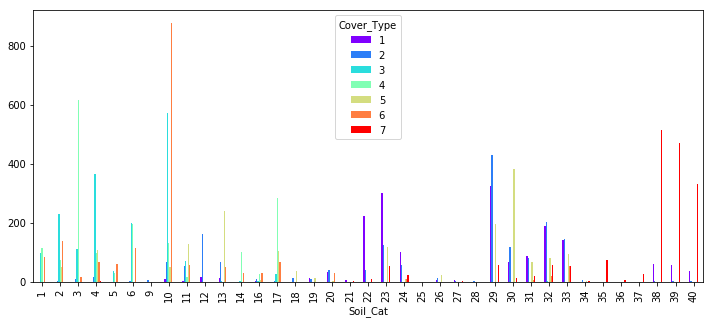

In [6]:
table = train_data_EDA.groupby(['Soil_Cat', 'Cover_Type'])['Count'].sum().unstack('Cover_Type')
table.plot(kind='bar', stacked=False, colormap='rainbow', figsize = (12, 5))

**Univariate Analysis**

We also examined the distributions for the 10 continuous variables, specifically to check for normality, which is required for some models such as Support Vector Machines (SVM) and Logistic Regression. Only Elevation and Hillshade 3 PM seem to have somewhat normal distributions. This suggested that the data will need scaling for most models.

To further examine natural breaks in the distribution, we increased the bins as shown below:

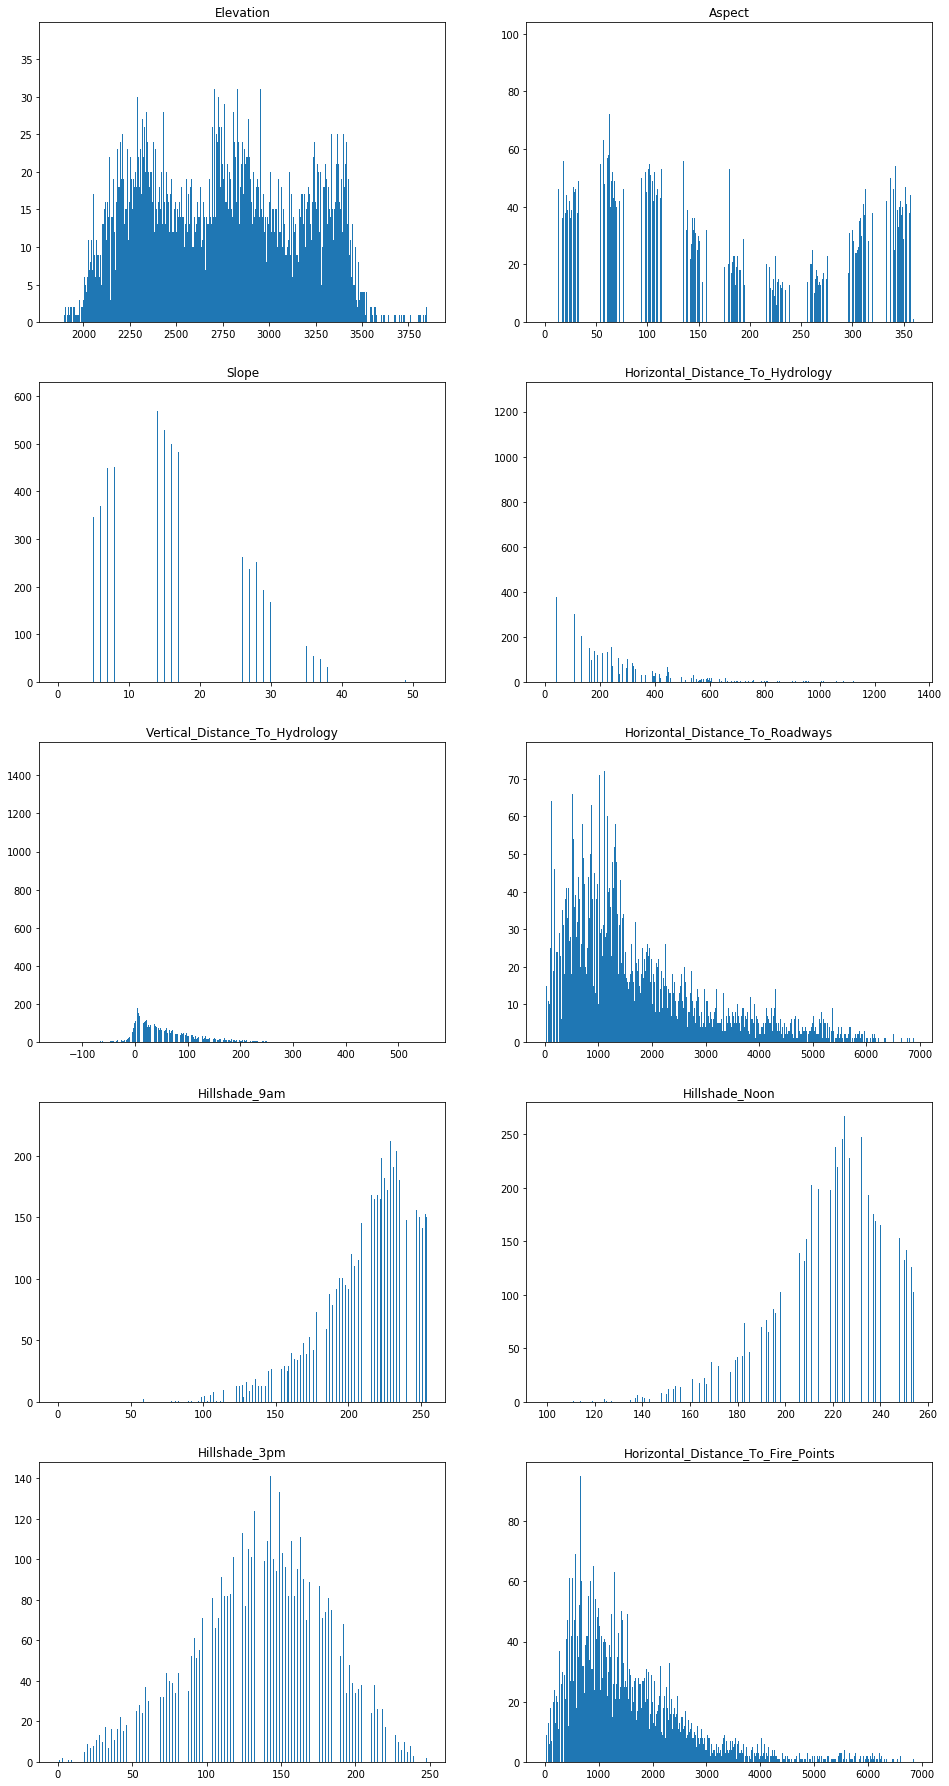

In [7]:
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=False, sharey=False, figsize = (16, 32))
x = [0,0,1,1,2,2,3,3,4,4]
for ii in np.arange(0, 10):
    ax = axes[x[ii], ii%2]
    ax.hist(train_data_EDA[list(train_data_EDA.columns)[ii]], bins=1000) ## We have 150 values for each feature; bins = 30 means we have 5 points per bin
    ax.set_title(list(train_data_EDA.columns)[ii])

plt.show()

**Key Explanatory Features Correlation Analysis**

Identify correlation between continuous variables and find the top pairs with the hightest correlations. 

Top 5 Correlations:
Hillshade_3pm                     Hillshade_9am                     0.780704
Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology    0.647454
Hillshade_3pm                     Aspect                            0.638642
                                  Hillshade_Noon                    0.610603
Slope                             Hillshade_Noon                    0.610317
dtype: float64


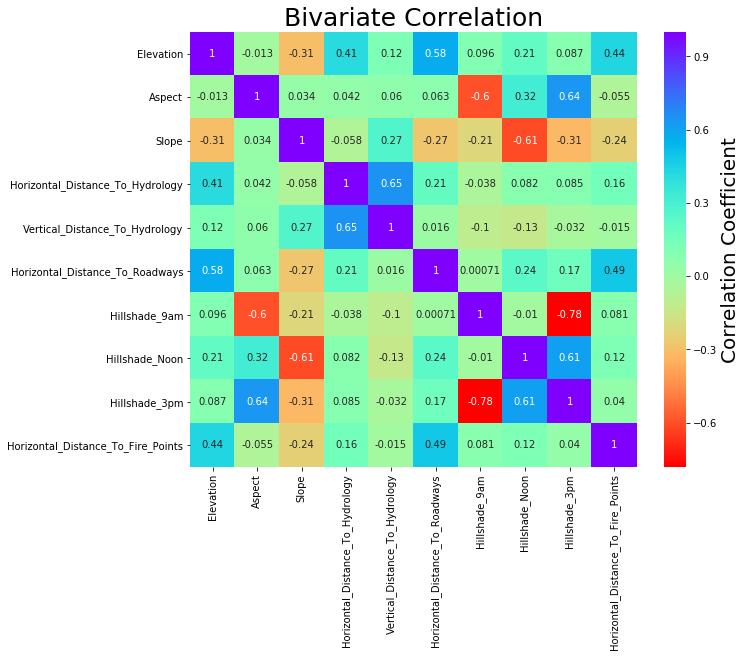

In [8]:
### Identify correlation between continuous variables
correlations = train_data_EDA[list(train_data_EDA.columns[:10])].corr()
names = list(train_data_EDA.columns[:10])

plt.figure(figsize=(10,8))
corr_plot = sns.heatmap(correlations, cmap = 'rainbow_r', annot = True, cbar_kws={'label': 'Correlation Coefficient'})
corr_plot.set_title('Bivariate Correlation', size=25)
corr_plot.figure.axes[-1].yaxis.label.set_size(20)

### Displays Top 5 Correlations

# Remove binary features
wild_names = ['Wilderness_Area' + str(i) for i in range(1, 5)]
soil_names = ['Soil_Type' + str(i) for i in range(1, 41)]
combined_binary_names = wild_names + soil_names

continuous_train_data = train_data_EDA.drop('Wilderness_Cat', axis = 1).drop('Soil_Cat', axis = 1)
for column in combined_binary_names:
    continuous_train_data = continuous_train_data.drop(column, axis = 1)

# Create correlation matrix
corr_matrix = continuous_train_data.corr()
    
# Remove correlation against self values
np.fill_diagonal(corr_matrix.values, 0)

# Identify highest correlations - Reference: https://stackoverflow.com/a/41453817
sorted_corrs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates()
num = 5
print("Top %i Correlations:" % num)
print(sorted_corrs[0:num])

The correlation matrix above reveals a few valuable insights useful in determining which features are most and least likely to be useful for application in machine learning models. The highest correlated continuous variables are hillshade_3pm and hillshade_9am at 78% correlation, thus these two columns are representing largely the same covariance in the data. Secondly, the Horizontal_distance_to_hydrology and Vertical_distance_to_hydrology have a 64% correlation, but this is to be expected as they are both representing distance to a water source. Ultimately, the correlation matrix is only useful for showing relationships between the continuous variables in the dataset which is only ~10 of the variables in the dataset. This dataset consists of primarily discrete variables, including the dependent variable (e.g. Cover Type), thus the correlation matrix can not be used for evaluating correlation between most of the independent variables and the dependent variable.

**Key Explanatory Features** --**SOS**

We also examined bivariate relationships between the continuous variables through scatterplots, color coded by cover type. In particular, we observed the most separability between the cover types with Elevation, suggesting that it may have more predictive power in our modeling. Cover types 1 and 7 tend to occur at higher elevation than cover types 4 and 6. However, we also observed that delineation between some cover types is less clear, especially between cover types 1 and 2 and 3 and 6.

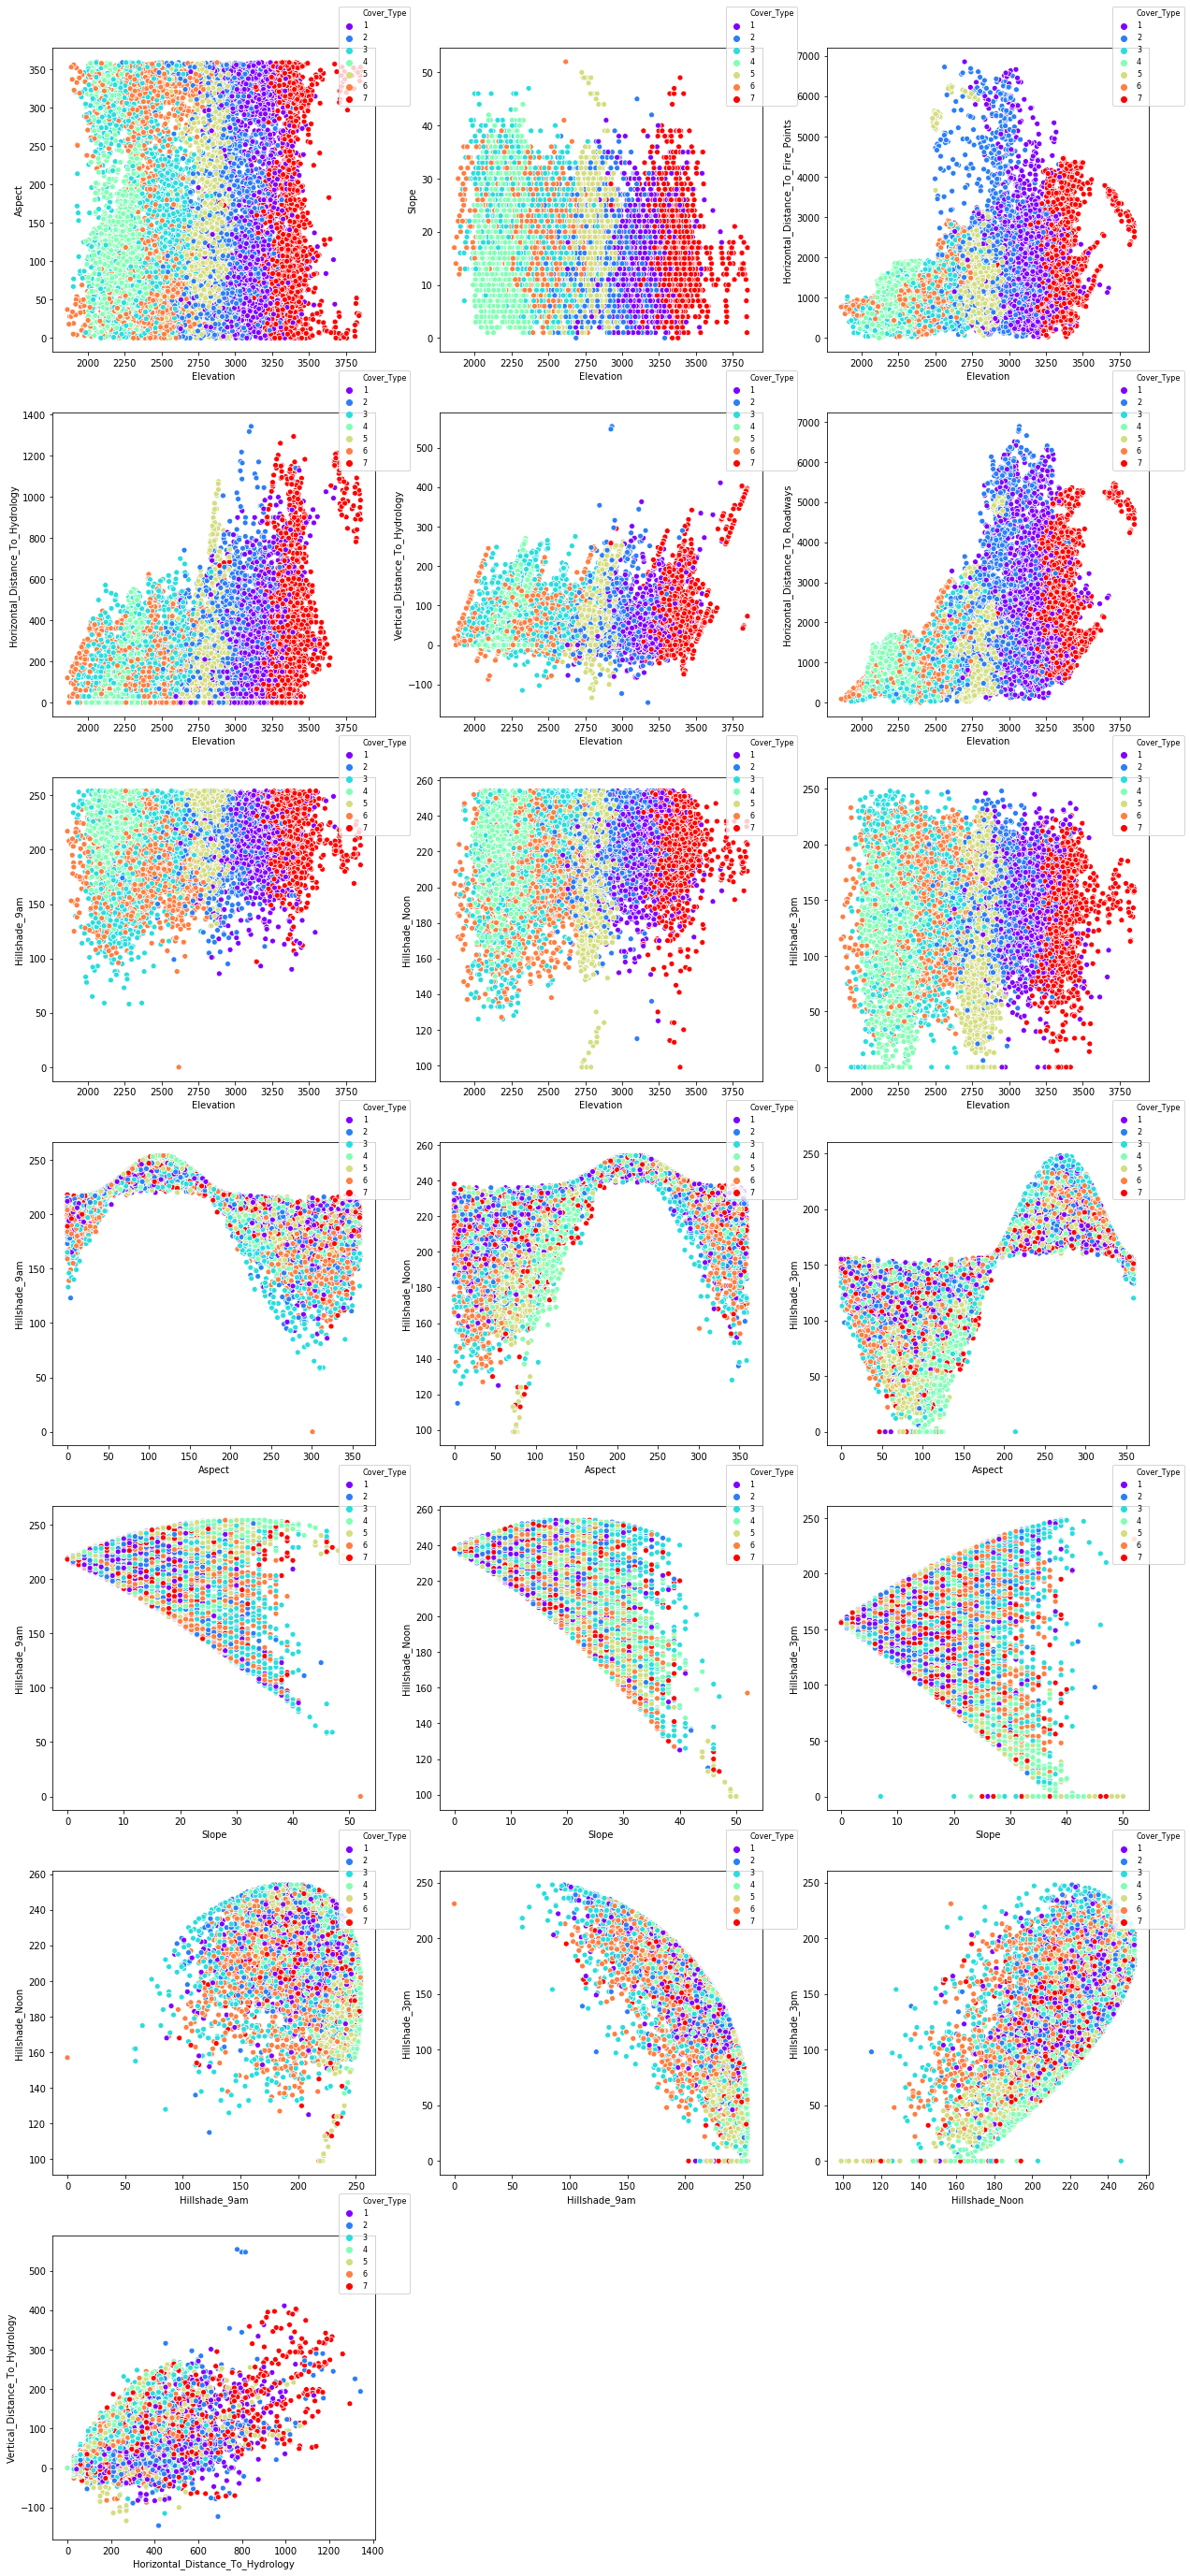

In [9]:
scatter_pairs = [['Elevation','Aspect'],['Elevation','Slope'],['Elevation','Horizontal_Distance_To_Fire_Points'],
                 ['Elevation','Horizontal_Distance_To_Hydrology'],['Elevation','Vertical_Distance_To_Hydrology'],
                 ['Elevation','Horizontal_Distance_To_Roadways'],
                 ['Elevation','Hillshade_9am'],['Elevation','Hillshade_Noon'],['Elevation','Hillshade_3pm'],
                 ['Aspect','Hillshade_9am'],['Aspect','Hillshade_Noon'],['Aspect','Hillshade_3pm'],
                 ['Slope','Hillshade_9am'],['Slope','Hillshade_Noon'],['Slope','Hillshade_3pm'],
                 ['Hillshade_9am','Hillshade_Noon'],['Hillshade_9am','Hillshade_3pm'],['Hillshade_Noon','Hillshade_3pm'],
                 ['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology']]

plt.figure(figsize=(21, 49))


z=1
for p in scatter_pairs:  
    plt.subplot(7,3,z)
    sns.scatterplot(x = p[0], y = p[1], data = train_data_EDA, hue = 'Cover_Type', palette="rainbow", legend = 'full')      
    plt.legend(loc='upper right',prop={'size': 8}, bbox_to_anchor=(1.12, 1.15))
    z+=1

-----

# Models


## 0. Shared Functions

The following functions were created to be used by more than one of the models below:

### 0.1 Continuous Variable Normalizer

In [10]:
def standard_transformation(train_data, dev_data, test_data):
    numeric_cols = list(train_data.columns[:10])
    
    scaled_train = train_data.copy(deep = True)
    scaled_dev = dev_data.copy(deep = True)
    scaled_test = test_data.copy(deep = True)

    
    scaler = StandardScaler()
    for n in numeric_cols:
        scaled_train[n] = scaler.fit_transform(train_data[n][:, np.newaxis])
        scaled_dev[n] = scaler.transform(dev_data[n][:, np.newaxis])
        scaled_test[n] = scaler.transform(test_data[n][:, np.newaxis])
    
    return scaled_train, scaled_dev, scaled_test

### 0.2 Adaboost Optimizer

In [11]:
def adaboost_optimzer(best_model, estimators, learning_rates, transformed_train, trainsformed_dev):
    
    #FUNCTION ARGUMENTS:
    #best_model - best version of the model to boost
    #estimators - a list of integers to input the n_estimators argument
    #learning_rates - list of learning rates to input to the learning_rate argument
    #trainsformed_train - the version of train_data post feature engineering used in the best_model
    #trainsformed_dev - the version of dev_data post feature engineering used in the best_model 
    
    results = []
    for n in estimators:
        for lr in learning_rates:
            abc = AdaBoostClassifier(base_estimator=best_model, n_estimators=n, learning_rate=lr, random_state = 0)
            abc.fit(transformed_train, train_labels)
            accuracy = abc.score(trainsformed_dev, dev_labels)
            
            results.append([n, lr, accuracy])
            
    results_t = pd.DataFrame(results)         
    results_t.columns = ["Maximum Number of Estimators", "Learning Rates", "Accuracy"]
    return results_t.sort_values(by = 'Accuracy', ascending = False)

## 1. Naive Bayes

#### Outline of Methodology

Given that our data set consists of both continuous and categorical variables, we must discretize our continuous variables in order to train a Naive Bayes model.  Since there is no way for us to turn our categorical variables (Wilderness Area and Soil Type) into continuous variables, we will limit our model building attempts to only Mutinomial Naive Bayes and Benoulli Naive Bayes training. To discretize the continuous variables, we will use the KBinsDiscretizer function which will turn all continuous variables into ordinal variables.  A separate function is written to further transform the discrete ordinal columns into binary columns for Bernoulli Naive Bayes model training.  

The following attempts were made in the code below:

1. To create a baseline for comparison, we start with features engineering by discretizing all continuous columns by the same number of bins. We then vary the number of bins according this list -  [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100].  For each number of bins, we fit the best Multinomial Naive Bayes model, using GridSearchCV to find the optimal alpha parameter.  We then measure the accuracy of the Multinomial Naive Bayes model on predictions for the dev_data for each number of bins used to discretize the train and dev data. 

2. The discretization is repeated for training Bernoulli Naive Bayes model, but an slightly modified function is used to transform all discrete ordinal columns into n binary columns, where n = number of bins.  The same set of bins list is used in this step, and GridSearchCV is again used to find the optimal smoothing parameter alpha.  We then compute the accuracy of each Bernoulli Naive Bayes model on the predictions for the dev_data for each number of bins used to discretize the train and dev data. 

3. Next, we built modified versions of both Multinomial and Binary transformation functions to allow the intake of a different number of bins per continuous column.  The customized binning numbers for each column are determined by the natural breaks we see in the data from univariate histograms of each of the 10 continuous variables in our EDA section.  We again used GridSearch CV to find the best alpha.  Additional discussion on how the custom set of bins is determined can be found below. 

4. Because the KBinsDiscretizer allows for discretization using strategy parameter = 'kmeans', we wanted to try kmeans discretization on train and dev data as part of features engineering.  Following methods 1 and 2, we created discrete bins of the continous variables using the same number of bins that varied from 2 to 8 bins for Multinomial Naive Bayes model training.  For Bernoulli Naive Bayes, additional transformation was done to transform discrete columns to binary columns. Models fitted to train_data features generated this way were used to predict dev_labels and accuracies were calculated for each number of bins. 

The following cell includes all functions used to create features engineering:

In [12]:
#deep copy train_data, dev_data, test_data for PCA
train_data_nb = train_data.copy(deep = True)
dev_data_nb = dev_data.copy(deep = True)
test_data_nb = test_data.copy(deep = True)

#Data Transformation Functions Used:
numeric_cols_nb = list(train_data_nb.columns[:10])


#Simple Multinomial Discretization.  Will transform train, dev and test sets simultaneously. 
def unif_transform_multinomial(train, dev, test, n):
    unifd = KBinsDiscretizer(n_bins = n, encode='ordinal', strategy='uniform')
    utrain = train.copy(deep = True)
    udev = dev.copy(deep = True)
    utest = test.copy(deep = True)
    
    for nc in numeric_cols_nb:
        utrain[nc] = unifd.fit_transform(utrain[nc][:, np.newaxis])
        udev[nc] = unifd.transform(udev[nc][:, np.newaxis])
        utest[nc] = unifd.transform(utest[nc][:, np.newaxis])
        
    utrain = utrain.astype(dtype = 'int64')
    udev = udev.astype(dtype = 'int64')
    utest = utest.astype(dtype = 'int64')

    return utrain, udev, utest

#Binomial transformation function for any single discrete column
def binomial(value, threshold):
    if value == threshold:
        return 1
    else:
        return 0

#Simple Binary Discretization using the Binomial transformation function on all columns.  
#Will transform train, dev and test sets simultaneously. 
def unif_transform_binomial(train, dev, test, n):
    btrain, bdev, btest = unif_transform_multinomial(train, dev, test, n)
    
    for nc in numeric_cols_nb:
        
        #find distinct set of all values
        value_list = set(list(btrain[nc]))
        
        #for each value, create binary column
        for value in value_list:
            col_name = nc+"_"+str(value)
            btrain[col_name] = np.vectorize(binomial)(value, btrain[nc])
            bdev[col_name] = np.vectorize(binomial)(value, bdev[nc])
            btest[col_name] = np.vectorize(binomial)(value, btest[nc])
        
        #drop multinomial column after all binary columns have been created
        btrain = btrain.drop(nc, axis = 1)
        bdev = bdev.drop(nc, axis = 1)
        btest = btest.drop(nc, axis = 1)

    return btrain, bdev, btest

#Modified Multinomial Discretization to allow for custom bin sizes for each column
def custom_transform_multinomial(train, dev, test, bins):
    #bins will be a dictionary provides a different number of bins for each column
    utrain = train.copy(deep = True)
    udev = dev.copy(deep = True)
    utest = test.copy(deep = True)
    
    for nc in numeric_cols_nb:
        unifd = KBinsDiscretizer(n_bins = bins[nc], encode='ordinal', strategy='uniform')
        utrain[nc] = unifd.fit_transform(utrain[nc][:, np.newaxis])
        udev[nc] = unifd.transform(udev[nc][:, np.newaxis])
        utest[nc] = unifd.transform(utest[nc][:, np.newaxis])
        
    utrain = utrain.astype(dtype = 'int64')
    udev = udev.astype(dtype = 'int64')
    utest = utest.astype(dtype = 'int64')

    return utrain, udev, utest

#Modified Binomial Discretization to allow for custom bin sizes for each column
def custom_transform_binomial(train, dev, test, bins):
    btrain, bdev, btest = custom_transform_multinomial(train, dev, test, bins)
    
    for nc in numeric_cols_nb:
        
        #find distinct set of all values
        value_list = set(list(btrain[nc]))
        
        #for each value, create binary column
        for value in value_list:
            col_name = nc+"_"+str(value)
            btrain[col_name] = np.vectorize(binomial)(value, btrain[nc])
            bdev[col_name] = np.vectorize(binomial)(value, bdev[nc])
            btest[col_name] = np.vectorize(binomial)(value, btest[nc])
        
        #drop multinomial column after all binary columns have been created
        btrain = btrain.drop(nc, axis = 1)
        bdev = bdev.drop(nc, axis = 1)
        btest = btest.drop(nc, axis = 1)

    return btrain, bdev, btest

#Simple KMeans Multinomial Discretization Function
def kmeans_transform_multinomial(train, dev, test, n):
    unifk = KBinsDiscretizer(n_bins = n, encode='ordinal', strategy='kmeans')
    ktrain = train.copy(deep = True)
    kdev = dev.copy(deep = True)
    ktest = test.copy(deep = True)
    
    for nc in numeric_cols_nb:
        ktrain[nc] = unifk.fit_transform(ktrain[nc][:, np.newaxis])
        kdev[nc] = unifk.transform(kdev[nc][:, np.newaxis])
        ktest[nc] = unifk.transform(ktest[nc][:, np.newaxis])
        
    ktrain = ktrain.astype(dtype = 'int64')
    kdev = kdev.astype(dtype = 'int64')
    ktest = ktest.astype(dtype = 'int64')

    return ktrain, kdev, ktest

#Simple KMeans Binomial Discretization Transformation Function
def kmeans_transform_binomial(train, dev, test, n):
    btrain, bdev, btest = kmeans_transform_multinomial(train, dev, test, n)
    
    for nc in numeric_cols_nb:
        
        #find distinct set of all values
        value_list = set(list(btrain[nc]))
        
        #for each value, create binary column
        for value in value_list:
            col_name = nc+"_"+str(value)
            btrain[col_name] = np.vectorize(binomial)(value, btrain[nc])
            bdev[col_name] = np.vectorize(binomial)(value, bdev[nc])
            btest[col_name] = np.vectorize(binomial)(value, btest[nc])
        
        #drop multinomial column after all binary columns have been created
        btrain = btrain.drop(nc, axis = 1)
        bdev = bdev.drop(nc, axis = 1)
        btest = btest.drop(nc, axis = 1)

    return btrain, bdev, btest

#Multinomial Discretization for PCA components
def PCA_transform_multinomial(train, dev, test, strat, n):
    unifk = KBinsDiscretizer(n_bins = n, encode='ordinal', strategy= strat)
    ptrain = pd.DataFrame(train).copy(deep = True)
    pdev = pd.DataFrame(dev).copy(deep = True)
    ptest = pd.DataFrame(test).copy(deep = True)
    
    ptrain = unifk.fit_transform(ptrain)
    pdev = unifk.transform(pdev)
    ptest = unifk.transform(ptest)
    
    ptrain = pd.DataFrame(ptrain).astype(dtype = 'int64')
    pdev = pd.DataFrame(pdev).astype(dtype = 'int64')
    ptest = pd.DataFrame(ptest).astype(dtype = 'int64')

    return ptrain, pdev, ptest

#Binomial Discretization Transformation Function for PCA Components
def PCA_transform_binomial(train, dev, test, strat, n):
    btrain, bdev, btest = PCA_transform_multinomial(train, dev, test,strat,n)
    btrain = pd.DataFrame(btrain)
    bdev = pd.DataFrame(bdev)
    btest = pd.DataFrame(btest)
    
    for i in range(btrain.shape[1]):
        
        #find distinct set of all values
        value_list = set(list(btrain[i]))
        
        #for each value, create binary column
        for value in value_list:
            col_name = str(i)+"_"+str(value)
            btrain[col_name] = np.vectorize(binomial)(value, btrain[i])
            bdev[col_name] = np.vectorize(binomial)(value, bdev[i])
            btest[col_name] = np.vectorize(binomial)(value, btest[i])
        
        #drop multinomial column after all binary columns have been created
        btrain = btrain.drop(i, axis = 1)
        bdev = bdev.drop(i, axis = 1)
        btest = btest.drop(i, axis = 1)

    return btrain, bdev, btest

**Uniform Discretization**

The following section shows the outcomes for methods (1) Simple Multinomial Discretization and (2) Simple Binomial Discretization and Transformation. 

In [15]:
bins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
alphas = {'classifier__alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}

def mnb_optimizer(bins, alphas):
    
    results = []

    for b in bins:
        mnb_train_data, mnb_dev_data, mnb_test_data  = unif_transform_multinomial(train_data_nb, dev_data_nb, test_data_nb, b)

        mnb_pipe = Pipeline([('classifier', MultinomialNB())])
        gs = GridSearchCV(mnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
        gs.fit(mnb_train_data, train_labels)
        best_alpha = gs.best_params_['classifier__alpha']

        mnb = MultinomialNB(alpha = best_alpha)
        mnb.fit(mnb_train_data, train_labels)
        results.append(["Multinomial","Uniform", b, best_alpha, mnb.score(mnb_dev_data, dev_labels)])
    
    results_t = pd.DataFrame(results)
    results_t.columns = ['Naive Bayes Model Type',"Discretization Strategy","Number of Bins per Variable", "Best Alpha", "Model Accuracy"]
    return results_t

mnb_optimizer(bins, alphas)

Naive Bayes Model Type Discretization Strategy  \
0             Multinomial                 Uniform   
1             Multinomial                 Uniform   
2             Multinomial                 Uniform   
3             Multinomial                 Uniform   
4             Multinomial                 Uniform   
5             Multinomial                 Uniform   
6             Multinomial                 Uniform   
7             Multinomial                 Uniform   
8             Multinomial                 Uniform   
9             Multinomial                 Uniform   
10            Multinomial                 Uniform   

    Number of Bins per Variable  Best Alpha  Model Accuracy  
0                             5         0.1        0.607804  
1                            10         0.0        0.609127  
2                            20         0.0        0.595238  
3                            30         0.0        0.567460  
4                            40         0.0        0.555556  
5                            50         0.0        0.546958  
6                            60         0.0        0.536376  
7                            70         0.0        0.533730  
8                            80         0.0        0.533069  
9                            90         0.0        0.531085  
10                          100         0.0        0.523148

In [16]:
def bnb_optimizer(bins, alphas):
    
    results = []

    for b in bins:
        bnb_train_data, bnb_dev_data, bnb_test_data  = unif_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, b)

        bnb_pipe = Pipeline([('classifier', BernoulliNB())])
        gs = GridSearchCV(bnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
        gs.fit(bnb_train_data, train_labels)
        best_alpha = gs.best_params_['classifier__alpha']

        bnb = BernoulliNB(alpha = best_alpha)
        bnb.fit(bnb_train_data, train_labels)
        results.append(['Binomial','Uniform', b, best_alpha, bnb.score(bnb_dev_data, dev_labels)])
    
    results_t = pd.DataFrame(results)
    results_t.columns = ['Naive Bayes Model Type',"Discretization Strategy","Number of Bins per Variable", "Best Alpha", "Model Accuracy"]
    return results_t

bnb_optimizer(bins, alphas)


Naive Bayes Model Type Discretization Strategy  \
0                Binomial                 Uniform   
1                Binomial                 Uniform   
2                Binomial                 Uniform   
3                Binomial                 Uniform   
4                Binomial                 Uniform   
5                Binomial                 Uniform   
6                Binomial                 Uniform   
7                Binomial                 Uniform   
8                Binomial                 Uniform   
9                Binomial                 Uniform   
10               Binomial                 Uniform   

    Number of Bins per Variable  Best Alpha  Model Accuracy  
0                             5        0.00        0.650132  
1                            10        0.00        0.664021  
2                            20        0.01        0.685847  
3                            30        0.01        0.686508  
4                            40        0.10        0.701058  
5                            50        0.50        0.693122  
6                            60        0.10        0.700397  
7                            70        0.10        0.691799  
8                            80        1.00        0.693122  
9                            90        0.10        0.692460  
10                          100        0.50        0.687831

From the results above, we see that the highest performing model using Multinomial Naive Bayes has an accuracy of 60.91% when all continuous columns are discretized using 10 bins and a smoothing parameter of alpha = 0.  On the other hand, the highest performing model using Bernoulli Naive Bayes has an accuracy of 70.10%, nearly a 10% increase, when all continuous columns are discretized using 50 bins.  The increase in Bernoulli Naive Bayes model fitting can be attributed to the fact that we have 44 binary features in our data but only 10 continous features, which would explain why Bernoulli Naive Bayes would outperform Multinomial Naive Bayes with simple discretization features engineering.

**Custom Discretization**

In the Uniform Discretization methods above, we discretized every single continuous column by an identical number of bins. However, this may not be the most optimal way to create discrete features, since the distribution of each continuous column is different.  We used the 1000 bins histograms in the earlier EDA analysis section **Univariate Analysis** to find the number of naturally occurring breaks in the data. The following 5 continuous variables have these numbers of bins due to naturally occuring breaks:

1. Aspect - 9
2. Slope - 5 
3. Hillshade_9am - 9
4. Hillshade_Noon - 12
5. Hillshade_3pm - 13

However, 5 of the 10 continuous variables do not have naturally occuring breaks.  For these variables, we first try to use a high bin number to discretized them (100, 200, 300), but these led to worse results in dev_labels predictive accuracy (56.15% and 68.58% for best Mutinomial and Bernoulli Naive Bayes Models respectively).  Since using high number of bins for the variables with no natural breaks did not work well, we turned to using smaller bin numbers.  To choose bin numbers, we used the result from simple discretization methodology above.  For Multinomial Naive Bayes, the best accuracies are achieved with uniform bins numbering 5, 10, and 20.  For Bernoulli Naive Bayes, the best accuracies are achieved with uniform bins numbering 40, 50, 60.  Therefore, in the following code block, we define bin numbers for 5 columns with no naturally occurring breaks using the best bin numbers from method 1 and 2 above.  The other 5 columns with naturally occuring breaks are given the number of bins we can see from histograms.  

In [17]:
#Defining custom bins for each column using a dictionary. 
#All variables that have naturally occuring breaks will have number of bins determined by counting
#Variables without naturally occuring bins will be discretized by 
custom_bins_5 = {'Elevation':5,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':5,
                  'Vertical_Distance_To_Hydrology':5, 'Horizontal_Distance_To_Roadways':5, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12,'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':5 }
custom_bins_10 = {'Elevation':10,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':10,
                  'Vertical_Distance_To_Hydrology':10, 'Horizontal_Distance_To_Roadways':10, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12, 'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':10 }
custom_bins_20 = {'Elevation':20,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':20,
                  'Vertical_Distance_To_Hydrology':20, 'Horizontal_Distance_To_Roadways':20, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12, 'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':20 }
custom_bins_40 = {'Elevation':40,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':40,
                  'Vertical_Distance_To_Hydrology':40, 'Horizontal_Distance_To_Roadways':40, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12,'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':40 }
custom_bins_50 = {'Elevation':50,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':50,
                  'Vertical_Distance_To_Hydrology':50, 'Horizontal_Distance_To_Roadways':50, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12, 'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':50 }
custom_bins_60 = {'Elevation':60,'Aspect':9, 'Slope':5, 'Horizontal_Distance_To_Hydrology':60,
                  'Vertical_Distance_To_Hydrology':60, 'Horizontal_Distance_To_Roadways':60, 
                  'Hillshade_9am': 9,'Hillshade_Noon':12, 'Hillshade_3pm': 13, 
                  'Horizontal_Distance_To_Fire_Points':60 }

cmnb_train_data_5, cmnb_dev_data_5, cmnb_test_data_5 = custom_transform_multinomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_5)
cmnb_train_data_10, cmnb_dev_data_10, cmnb_test_data_10 = custom_transform_multinomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_10)
cmnb_train_data_20, cmnb_dev_data_20, cmnb_test_data_20 = custom_transform_multinomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_20)

cbnb_train_data_40, cbnb_dev_data_40, cbnb_test_data_40 = custom_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_40)
cbnb_train_data_50, cbnb_dev_data_50, cbnb_test_data_50 = custom_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_50)
cbnb_train_data_60, cbnb_dev_data_60, cbnb_test_data_60 = custom_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, custom_bins_60)



results_3 = []
#Mutinomial Naive Bayes for Custom Bin Numbers
mnb_pipe = Pipeline([('classifier', MultinomialNB())])
gsm = GridSearchCV(mnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)


#custom_bins_5, where 5 variables without naturally occuring bins are discretized by 5 bins
gsm.fit(cmnb_train_data_5, train_labels)
best_alpha_mnb1 = gsm.best_params_['classifier__alpha']
mnb1 = MultinomialNB(alpha = best_alpha_mnb1)
mnb1.fit(cmnb_train_data_5, train_labels)
results_3.append(['Mutinomial',5, best_alpha_mnb1, mnb1.score(cmnb_dev_data_5, dev_labels)])
    
#custom_bins_10, where 5 variables without naturally occuring bins are discretized by 10 bins
gsm.fit(cmnb_train_data_10, train_labels)
best_alpha_mnb2 = gsm.best_params_['classifier__alpha']
mnb2 = MultinomialNB(alpha = best_alpha_mnb2)
mnb2.fit(cmnb_train_data_10, train_labels)
results_3.append(['Mutinomial',10, best_alpha_mnb2, mnb2.score(cmnb_dev_data_10, dev_labels)])

#custom_bins_20, where 5 variables without naturally occuring bins are discretized by 20 bins
gsm.fit(cmnb_train_data_20, train_labels)
best_alpha_mnb3 = gsm.best_params_['classifier__alpha']
mnb3 = MultinomialNB(alpha = best_alpha_mnb3)
mnb3.fit(cmnb_train_data_20, train_labels)
results_3.append(['Mutinomial',20, best_alpha_mnb3, mnb3.score(cmnb_dev_data_20, dev_labels)])


#Bernoulli Naive Bayes for Custom Bin Numbers
bnb_pipe = Pipeline([('classifier', BernoulliNB())])
gsb = GridSearchCV(bnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)

#custom_bins_40, where 5 variables without naturally occuring bins are discretized by 40 bins
gsb.fit(cbnb_train_data_40, train_labels)
best_alpha_bnb1 = gsb.best_params_['classifier__alpha']
bnb1 = BernoulliNB(alpha = best_alpha_bnb1)
bnb1.fit(cbnb_train_data_40, train_labels)
results_3.append(['Binomial',40, best_alpha_bnb1, bnb1.score(cbnb_dev_data_40, dev_labels)])

#custom_bins_50, where 5 variables without naturally occuring bins are discretized by 50 bins
gsb.fit(cbnb_train_data_50, train_labels)
best_alpha_bnb2 = gsb.best_params_['classifier__alpha']
bnb2 = BernoulliNB(alpha = best_alpha_bnb2)
bnb2.fit(cbnb_train_data_50, train_labels)
results_3.append(['Binomial',50, best_alpha_bnb2, bnb2.score(cbnb_dev_data_50, dev_labels)])

#custom_bins_60, where 5 variables without naturally occuring bins are discretized by 60 bins
gsb.fit(cbnb_train_data_60, train_labels)
best_alpha_bnb3 = gsb.best_params_['classifier__alpha']
bnb3 = BernoulliNB(alpha = best_alpha_bnb3)
bnb3.fit(cbnb_train_data_60, train_labels)
results_3.append(['Binomial',60, best_alpha_bnb3, bnb3.score(cbnb_dev_data_60, dev_labels)])

results_t3 = pd.DataFrame(results_3)
results_t3.columns = ["Naive Bayes Model Type", "Number of Bins for Continuous Variables with No Natural Breaks", "Best Alpha", "Model Accuracy"]

results_t3

Naive Bayes Model Type  \
0             Mutinomial   
1             Mutinomial   
2             Mutinomial   
3               Binomial   
4               Binomial   
5               Binomial   

   Number of Bins for Continuous Variables with No Natural Breaks  Best Alpha  \
0                                                  5                     0.00   
1                                                 10                     0.00   
2                                                 20                     0.00   
3                                                 40                     0.01   
4                                                 50                     0.10   
5                                                 60                     0.10   

   Model Accuracy  
0        0.616402  
1        0.615741  
2        0.604497  
3        0.700397  
4        0.693783  
5        0.697090

From these custom binning method results, it appears that customizing bin numbers for discretization did little to improve the accuracy of Multinomial Naive Bayes models (the best performing model ouputs 61.64% accuracy compared to  60.91% for no bins customization) and showed no improvement for the accuracies of the best Bernoulli Naive Bayes models. From other tests we ran, increasing the number of bins to 100 or more for variables with no naturally occuring breaks actually lowers the accuracy even further.  

**Kmeans Discretization**

In other experiments we ran, we also tried a different discretization strategy for KBinsDiscretizer.  Instead of using 'uniform' for the strategy parameter, which ensures that all bins have identical widths, we tried 'kmeans' for the strategy parameter as well. The 'kmeans' discretization strategy creates bins such that values in each bin have the same nearest center of a 1D k-means cluster.  In these experiments, we applied the same number of bins to all continuous variables, just as we did with uniform discretization, since we found that custom number of bins for discretization did not improve accuracy.

In [18]:
kmeans_bins = [i for i in range(2, 9)]
def mnb_optimizer_kmeans(bins, alphas):
    
    results = []

    for b in bins:
        mnb_train_data, mnb_dev_data, mnb_test_data  = kmeans_transform_multinomial(train_data_nb, dev_data_nb, test_data_nb, b)

        mnb_pipe = Pipeline([('classifier', MultinomialNB())])
        gs = GridSearchCV(mnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
        gs.fit(mnb_train_data, train_labels)
        best_alpha = gs.best_params_['classifier__alpha']

        mnb = MultinomialNB(alpha = best_alpha)
        mnb.fit(mnb_train_data, train_labels)
        results.append(['Multinomial','KMeans', b, best_alpha, mnb.score(mnb_dev_data, dev_labels)])
    
    results_t = pd.DataFrame(results)
    results_t.columns = ["Naive Bayes Model Type","Discretization Strategy","Number of Bins per Variable", "Best Alpha", "Model Accuracy"]
    return results_t

mnb_optimizer_kmeans(kmeans_bins, alphas)

Naive Bayes Model Type Discretization Strategy  Number of Bins per Variable  \
0            Multinomial                  KMeans                            2   
1            Multinomial                  KMeans                            3   
2            Multinomial                  KMeans                            4   
3            Multinomial                  KMeans                            5   
4            Multinomial                  KMeans                            6   
5            Multinomial                  KMeans                            7   
6            Multinomial                  KMeans                            8   

   Best Alpha  Model Accuracy  
0         0.0        0.610450  
1         0.1        0.596561  
2         0.0        0.610450  
3         0.0        0.608466  
4         1.0        0.609788  
5         0.0        0.610450  
6         0.1        0.609788

In [19]:
kmeans_bins = [i for i in range(2, 9)]
def bnb_optimizer_kmeans(bins, alphas):
    
    results = []

    for b in bins:
        bnb_train_data, bnb_dev_data, bnb_test_data  = kmeans_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, b)

        bnb_pipe = Pipeline([('classifier', BernoulliNB())])
        gs = GridSearchCV(bnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
        gs.fit(bnb_train_data, train_labels)
        best_alpha = gs.best_params_['classifier__alpha']

        bnb = BernoulliNB(alpha = best_alpha)
        bnb.fit(bnb_train_data, train_labels)
        results.append(['Multinomial','KMeans', b, best_alpha, bnb.score(bnb_dev_data, dev_labels)])
    
    results_t = pd.DataFrame(results)
    results_t.columns = ["Naive Bayes Model Type","Discretization Strategy","Number of Bins per Variable","Best Alpha", "Model Accuracy"]
    return results_t

bnb_optimizer_kmeans(kmeans_bins, alphas)

Naive Bayes Model Type Discretization Strategy  Number of Bins per Variable  \
0            Multinomial                  KMeans                            2   
1            Multinomial                  KMeans                            3   
2            Multinomial                  KMeans                            4   
3            Multinomial                  KMeans                            5   
4            Multinomial                  KMeans                            6   
5            Multinomial                  KMeans                            7   
6            Multinomial                  KMeans                            8   

   Best Alpha  Model Accuracy  
0         0.0        0.590608  
1         0.0        0.608466  
2         0.0        0.623677  
3         0.0        0.656746  
4         0.1        0.660714  
5         0.0        0.666005  
6         0.0        0.664683

Kmeans discretization did not show better results than Uniform discretization.  We were limited to at most 8 bins due to errors regarding bins not increasing monotonically for bin numbers exceeding 9.   IMPROVEMENT FOR KMEANS, ADD HERE

**Best Naive Bayes Model and Error Analysis**

In [28]:
best_bnb_train_data, best_bnb_dev_data, best_bnb_test_data  = unif_transform_binomial(train_data_nb, dev_data_nb, test_data_nb, 40)
best_bnb = BernoulliNB(alpha = 0.1)
best_bnb.fit(best_bnb_train_data, train_labels)
pre_test_labels = best_bnb.predict(best_bnb_test_data)

print("Best Model Accuracy on test_data:", np.sum(pre_test_labels==test_labels)/test_labels.size)
print(classification_report(test_labels, pre_test_labels))
print(confusion_matrix(test_labels, pre_test_labels))


Best Model Accuracy on test_data: 0.7037037037037037
              precision    recall  f1-score   support

           1       0.64      0.60      0.62       220
           2       0.63      0.60      0.61       208
           3       0.61      0.53      0.57       220
           4       0.86      0.92      0.89       212
           5       0.69      0.78      0.73       227
           6       0.64      0.63      0.63       206
           7       0.81      0.87      0.84       219

   micro avg       0.70      0.70      0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70      1512

[[132  39   1   0  11   0  37]
 [ 40 124   3   0  26   7   8]
 [  0   0 117  21  25  57   0]
 [  0   0  15 195   0   2   0]
 [  6  28   8   0 177   8   0]
 [  0   3  47  11  16 129   0]
 [ 27   2   0   0   0   0 190]]


**Conclusion on Naive Bayes**
why does model fall short compared to other models.

## 2. Principle Component Analysis Ensembles

Since our features are a mixed of continuous and discrete variables, we wanted to test if principle component analysis on the continuous features can help improve any of our existing models.  To prepare the data for PCA, we extracted only the continuous columns and scaled all columns using StandardScaler (ecapsulated in standard_transformation()). 

In [20]:
#deep copy train_data, dev_data, test_data for PCA
train_data_pca = train_data.copy(deep = True).astype(dtype = 'float64')
dev_data_pca = dev_data.copy(deep = True).astype(dtype = 'float64')
test_data_pca = test_data.copy(deep = True).astype(dtype = 'float64')

#in order to perform PCA, we will need to drop all of the categorical variables - 
train_data_pca = train_data_pca.drop(list(train_data.columns[10:]), axis = 1)
dev_data_pca = dev_data_pca.drop(list(train_data.columns[10:]), axis = 1)
test_data_pca = test_data_pca.drop(list(train_data.columns[10:]), axis = 1)

#so that variables with large numbers are not given higher weights, 
#we will normalize every column using the standard scaler

scaled_train_pca, scaled_dev_pca, scaled_test_pca = standard_transformation(train_data_pca, dev_data_pca, test_data_pca)

### 2.1 Gaussian Mixture Model using PCA

To test which number of PCA components is most optimum, we decided do a series of experiments using PCA transformations and Gaussian Mixture Models fitting.  The following algorithm works as follows:
1) We project the normalized train_data and dev_data into c principle components
2) We fit Gaussian Mixture model on 7 subsets of the pca transformed train_data.  The train_data is subsetted by train_labels, where one subset is created for each of the 7 Cover_Type values
3) The for each of the 7 subsets, the GMM model scores on the dev_set is recorded.  
4) For each data point in the dev_data, the highest GMM model score corresponds to the model prediction label
5) Accuracy is calculated by comparing predicted labels on the dev_data to the dev_labels

The above algorithm is then repeated within an optimzer function, where the number of PCA components, the number of GMM components and the GMM covariance matrix type is varied, to find the best combination of PCA components count, GMM components count, and covariance matrix type.  In the original set of experiments we ran, we tested optimization for 1-9 PCA components, for 1-30 GMM components, and for all 4 GMM covariance matrix types (['spherical', 'diag', 'tied', 'full']).  Because the optimizer takes a long time to run, we narrowed the ranges for the 3 parameters to values that encompass the parameters needed to achieve the top 10 accuracies.  All top accuracies were achieved by covariance matrix type = 'full', 7-9 PCA components, and 21-30 GMM components.  The code below shows the subset of experiments which performed the best

In [31]:
#create a reusable function that takes any number of principle components, 
#any number of GMM compontents and covariance matrix type
#fits a GMM on projected train_d and predicts labels for test_d()
def pca_gmm(cmt, c, n, train_d, train_l, test_d, test_l):
    
    # project train data to c components
    pca = PCA(n_components = c)
    pca.fit(train_d)
    
    # transform both train and test data
    transformed_train_pca = pca.transform(train_d) 
    transformed_test_pca = pca.transform(test_d)
    
    
    gmm = GaussianMixture(n_components=n, covariance_type=cmt, random_state = 0)
    predicted_probs = np.zeros([transformed_test_pca.shape[0], 7])
    for i in range(1, 8):
        gmm.fit(transformed_train_pca[train_l == i])
        predicted_probs[:, i-1] = gmm.score_samples(transformed_test_pca)

    # the predicted label for each test_d datapoint will correspond to the label with the highest gmm probability
    predicted_labels = np.argmax(predicted_probs, axis = 1) + np.ones(transformed_test_pca.shape[0])
    
    accuracy = np.sum(predicted_labels == test_l)/test_l.size
    return accuracy, transformed_train_pca, transformed_test_pca, predicted_labels
    

#optimize for the best covariance matrix type, number of principle components, number of GMM components

def pca_gmm_optimzer():
    
    #the following is chosen from the top 30 results:
    pca_components = [i for i in range(7, 10)]
    cov_matrix_type = ['full']
    gmm_components = [i for i in range(21, 31)]
    
    results = []
    
    for cmt in cov_matrix_type:
        for c in pca_components:
            for n in gmm_components:
                accuracy, transformed_train_pca, transformed_test_pca,  predicted_labels = pca_gmm(cmt, c, n, scaled_train_pca, train_labels, scaled_dev_pca, dev_labels)
                results.append([cmt, c, n, accuracy])
    
    results_t = pd.DataFrame(results)         
    results_t.columns = ["Covariance Matrix Type", "Principle Components", "GMM Components", "Accuracy"]
    return results_t.sort_values(by = 'Accuracy', ascending = False)

pca_gmm_optimzer()

Covariance Matrix Type  Principle Components  GMM Components  Accuracy
7                    full                     7              28  0.727513
5                    full                     7              26  0.724206
8                    full                     7              29  0.722222
2                    full                     7              23  0.720899
10                   full                     8              21  0.720899
1                    full                     7              22  0.719577
17                   full                     8              28  0.718915
19                   full                     8              30  0.718254
6                    full                     7              27  0.716270
9                    full                     7              30  0.715608
16                   full                     8              27  0.715608
29                   full                     9              30  0.714947
18                   full                     8              29  0.714286
28                   full                     9              29  0.713624
27                   full                     9              28  0.713624
0                    full                     7              21  0.713624
3                    full                     7              24  0.712963
26                   full                     9              27  0.711640
4                    full                     7              25  0.710317
14                   full                     8              25  0.709656
11                   full                     8              22  0.708995
13                   full                     8              24  0.702381
15                   full                     8              26  0.701720
23                   full                     9              24  0.697751
21                   full                     9              22  0.697090
12                   full                     8              23  0.696429
25                   full                     9              26  0.696429
22                   full                     9              23  0.693122
24                   full                     9              25  0.686508
20                   full                     9              21  0.675265

From the series of experiments run above, the best performing GMM model uses 7 PCA components and 28 GMM components, achieving an accuracy of 72.75% on predicting dev_labels. Using the parameters which achieved the highest accuracy, we run the PCA plus GMM algorithm on the test_data set once, and achive an accuracy of 71.89%

In [32]:
# using the best parameters, calculate the accuracy on test_data:
best_gmm_accuracy, best_gmm_train_pca, best_gmm_test_pca,  best_gmm_pred_labels = pca_gmm('full', 7, 28, scaled_train_pca, train_labels, scaled_test_pca, test_labels)

print("Best Model Accuracy on test_data:", best_gmm_accuracy)
print(classification_report(test_labels, best_gmm_pred_labels))
print(confusion_matrix(test_labels, best_gmm_pred_labels))

Best Model Accuracy on test_data: 0.718915343915344
              precision    recall  f1-score   support

           1       0.59      0.57      0.58       220
           2       0.52      0.57      0.54       208
           3       0.65      0.64      0.64       220
           4       0.94      0.89      0.92       212
           5       0.83      0.81      0.82       227
           6       0.66      0.71      0.68       206
           7       0.88      0.84      0.86       219

   micro avg       0.72      0.72      0.72      1512
   macro avg       0.72      0.72      0.72      1512
weighted avg       0.72      0.72      0.72      1512

[[125  68   1   0   6   1  19]
 [ 49 119  12   1  18   4   5]
 [  1   8 140   7   9  55   0]
 [  0   0  11 189   0  12   0]
 [  6  24   7   0 184   4   2]
 [  0   6  45   4   5 146   0]
 [ 31   4   0   0   0   0 184]]


The PCA plus GMM algorithm did not perform as well as Decision Tree, Random Forest, or Support Vector Machine.  However, this approach is excluding all of the categorical variables in the data set.  Next, we will join the PCA transformed data with the categorical variables and test if this can improve our Naive Bayes or Decision Tree models.

### 2.2 Naive Bayes using PCA

From the results above, we know that one of the possibilities that Naive Bayes may fall short is due to the failure to meet the conditional independence criteria. In particular, the Cover Type variable appears to be conditionally dependent on pairs of continuous variables, as shown in our features selection scatter plots.    


Principle components analysis can project our continous variables into orthogonal components that are linearly independent. As a result, this might assist in Naive Bayes model fitting if we use indpendent principle components to replace our continuous variables.  Furthermore, Naive Bayes allows us to combine the categorical Wilderness_Area and Soil_Type variables with the principle components, which we could not do for the Gaussian Mixture Models in the section above.  From the PCA and GMM model analysis, we found that the best performing GMM models use 7, 8, or 9 principle components.  We will use these 3 number of components to transform the data, apply both uniform and kmeans discretization to the continous variables for fitting Multinomial Naive Bayes, followed by applying binomial transformation on the discretized continous variables data for fitting Bernoulli Naive Bayes.  

In [26]:
#preserve the categorical columns in a numpy array
train_cat = train_data_nb[list(train_data_nb.columns[10:])].copy(deep='True').values
dev_cat = dev_data_nb[list(dev_data_nb.columns[10:])].copy(deep='True').values
test_cat = test_data_nb[list(test_data_nb.columns[10:])].copy(deep='True').values

pca_components = [7,8,9]

def pca_nb(c, train_d, dev_d, test_d):
    
    bins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    alphas = {'classifier__alpha': [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    kmeans_bins = [i for i in range(2, 9)]
    
    for c in pca_components:
        pca = PCA(n_components = c)
        pca.fit(train_d)
        transformed_train_pca = pca.transform(train_d) 
        transformed_dev_pca = pca.transform(dev_d)
        transformed_test_pca = pca.transform(test_d)

        results = []

        for i in [5, 10, 15, 20]:
            mnb_train_data, mnb_dev_data, mnb_test_data  = PCA_transform_multinomial(transformed_train_pca, transformed_dev_pca, transformed_test_pca,'uniform', i)
            
            #before fitting naive bayes model, reattach the categorical variables data to the train, dev, and test sets
            mnb_train_data = mnb_train_data.values
            mnb_dev_data = mnb_dev_data.values
            mnb_test_data = mnb_test_data.values
            
            mnb_train_data = np.hstack((mnb_train_data, train_cat))
            mnb_dev_data = np.hstack((mnb_dev_data, dev_cat))
            mnb_test_data =np.hstack((mnb_test_data, test_cat))
            
            mnb_pipe = Pipeline([('classifier', MultinomialNB())])
            gs = GridSearchCV(mnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
            gs.fit(mnb_train_data, train_labels)
            best_alpha = gs.best_params_['classifier__alpha']

            mnb = MultinomialNB(alpha = best_alpha)
            mnb.fit(mnb_train_data, train_labels)
            results.append(["Multinomial","Uniform", c, i, best_alpha, mnb.score(mnb_dev_data, dev_labels)])
        
        for i in [40, 45, 50, 55, 60]:
            bnb_train_data, bnb_dev_data, bnb_test_data  = PCA_transform_binomial(transformed_train_pca, transformed_dev_pca, transformed_test_pca,'uniform', i)

            #before fitting naive bayes model, reattach the categorical variables data to the train, dev, and test sets
            bnb_train_data = bnb_train_data.values
            bnb_dev_data = bnb_dev_data.values
            bnb_test_data = bnb_test_data.values
            
            bnb_train_data = np.hstack((bnb_train_data, train_cat))
            bnb_dev_data = np.hstack((bnb_dev_data, dev_cat))
            bnb_test_data =np.hstack((bnb_test_data, test_cat))
            
            bnb_pipe = Pipeline([('classifier', BernoulliNB())])
            gs = GridSearchCV(bnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
            gs.fit(bnb_train_data, train_labels)
            best_alpha = gs.best_params_['classifier__alpha']

            bnb = BernoulliNB(alpha = best_alpha)
            bnb.fit(bnb_train_data, train_labels)
            results.append(['Binomial','Uniform', c, i, best_alpha, bnb.score(bnb_dev_data, dev_labels)])
            
        for i in kmeans_bins:
            mnb_train_data, mnb_dev_data, mnb_test_data  = PCA_transform_multinomial(transformed_train_pca, transformed_dev_pca, transformed_test_pca,'kmeans', i)

            #before fitting naive bayes model, reattach the categorical variables data to the train, dev, and test sets
            mnb_train_data = mnb_train_data.values
            mnb_dev_data = mnb_dev_data.values
            mnb_test_data = mnb_test_data.values
            
            mnb_train_data = np.hstack((mnb_train_data, train_cat))
            mnb_dev_data = np.hstack((mnb_dev_data, dev_cat))
            mnb_test_data =np.hstack((mnb_test_data, test_cat))
            
            mnb_pipe = Pipeline([('classifier', MultinomialNB())])
            gs = GridSearchCV(mnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
            gs.fit(mnb_train_data, train_labels)
            best_alpha = gs.best_params_['classifier__alpha']

            mnb = MultinomialNB(alpha = best_alpha)
            mnb.fit(mnb_train_data, train_labels)
            results.append(['Multinomial','KMeans', c, i, best_alpha, mnb.score(mnb_dev_data, dev_labels)])
    
        for i in kmeans_bins:
            bnb_train_data, bnb_dev_data, bnb_test_data  = PCA_transform_binomial(transformed_train_pca, transformed_dev_pca, transformed_test_pca,'kmeans', i)

            #before fitting naive bayes model, reattach the categorical variables data to the train, dev, and test sets
            bnb_train_data = bnb_train_data.values
            bnb_dev_data = bnb_dev_data.values
            bnb_test_data = bnb_test_data.values
            
            bnb_train_data = np.hstack((bnb_train_data, train_cat))
            bnb_dev_data = np.hstack((bnb_dev_data, dev_cat))
            bnb_test_data =np.hstack((bnb_test_data, test_cat))
            
            bnb_pipe = Pipeline([('classifier', BernoulliNB())])
            gs = GridSearchCV(bnb_pipe, param_grid = alphas, iid = True, refit = True, cv=5, return_train_score=True)
            gs.fit(bnb_train_data, train_labels)
            best_alpha = gs.best_params_['classifier__alpha']

            bnb = BernoulliNB(alpha = best_alpha)
            bnb.fit(bnb_train_data, train_labels)
            results.append(['Multinomial','KMeans', c, i, best_alpha, bnb.score(bnb_dev_data, dev_labels)])

    
    results_t = pd.DataFrame(results)
    results_t.columns = ['Naive Bayes Model Type',"Discretization Strategy", "Number of Principal Components", "Number of Bins per Variable", "Best Alpha", "Model Accuracy"]
    return results_t.sort_values(by = 'Model Accuracy', ascending = False)

pca_nb(pca_components, scaled_train_pca, scaled_dev_pca, scaled_test_pca)

Naive Bayes Model Type Discretization Strategy  \
5                Binomial                 Uniform   
8                Binomial                 Uniform   
7                Binomial                 Uniform   
21            Multinomial                  KMeans   
4                Binomial                 Uniform   
6                Binomial                 Uniform   
22            Multinomial                  KMeans   
20            Multinomial                  KMeans   
19            Multinomial                  KMeans   
18            Multinomial                  KMeans   
2             Multinomial                 Uniform   
14            Multinomial                  KMeans   
3             Multinomial                 Uniform   
15            Multinomial                  KMeans   
13            Multinomial                  KMeans   
17            Multinomial                  KMeans   
12            Multinomial                  KMeans   
1             Multinomial                 Uniform   
11            Multinomial                  KMeans   
0             Multinomial                 Uniform   
16            Multinomial                  KMeans   
10            Multinomial                  KMeans   
9             Multinomial                  KMeans   

    Number of Principal Components  Number of Bins per Variable  Best Alpha  \
5                                9                           45        1.00   
8                                9                           60        0.10   
7                                9                           55        0.10   
21                               9                            7        0.01   
4                                9                           40        0.01   
6                                9                           50        0.10   
22                               9                            8        0.00   
20                               9                            6        0.10   
19                               9                            5        0.00   
18                               9                            4        0.00   
2                                9                           15        2.00   
14                               9                            7       10.00   
3                                9                           20        0.00   
15                               9                            8       10.00   
13                               9                            6       10.00   
17                               9                            3        0.10   
12                               9                            5       10.00   
1                                9                           10       10.00   
11                               9                            4       10.00   
0                                9                            5        0.10   
16                               9                            2        0.50   
10                               9                            3        0.00   
9                                9                            2        0.00   

    Model Accuracy  
5         0.655423  
8         0.649471  
7         0.646164  
21        0.644841  
4         0.644180  
6         0.642196  
22        0.641534  
20        0.640212  
19        0.636905  
18        0.628968  
2         0.620370  
14        0.620370  
3         0.619709  
15        0.613095  
13        0.612434  
17        0.609127  
12        0.605820  
1         0.601852  
11        0.599868  
0         0.597884  
16        0.593915  
10        0.591931  
9         0.584656

In [35]:
best_pca = PCA(n_components = 9)
best_pca.fit(scaled_train_pca)

best_pca_nb_train = best_pca.transform(scaled_train_pca) 
best_pca_nb_dev = best_pca.transform(scaled_dev_pca)
best_pca_nb_test = best_pca.transform(scaled_test_pca)

best_pca_nb_train, best_pca_nb_dev, best_pca_nb_test  = PCA_transform_binomial(best_pca_nb_train, best_pca_nb_dev, best_pca_nb_test,'uniform', 45)

best_pca_nb_train = best_pca_nb_train.values
best_pca_nb_dev = best_pca_nb_dev.values
best_pca_nb_test = best_pca_nb_test.values
            
best_pca_nb_train = np.hstack((best_pca_nb_train, train_cat))
best_pca_nb_dev = np.hstack((best_pca_nb_dev, dev_cat))
best_pca_nb_test = np.hstack((best_pca_nb_test, test_cat))

best_bnb = BernoulliNB(alpha = 1)
best_bnb.fit(best_pca_nb_train, train_labels)
pre_test_labels = best_bnb.predict(best_pca_nb_test)

print("Best Model Accuracy on test_data:", np.sum(pre_test_labels==test_labels)/test_labels.size)
print(classification_report(test_labels, pre_test_labels))
print(confusion_matrix(test_labels, pre_test_labels))

Best Model Accuracy on test_data: 0.6468253968253969
              precision    recall  f1-score   support

           1       0.56      0.53      0.54       220
           2       0.56      0.49      0.52       208
           3       0.58      0.45      0.51       220
           4       0.74      0.80      0.77       212
           5       0.62      0.75      0.68       227
           6       0.59      0.67      0.63       206
           7       0.84      0.84      0.84       219

   micro avg       0.65      0.65      0.65      1512
   macro avg       0.64      0.65      0.64      1512
weighted avg       0.64      0.65      0.64      1512

[[116  50   1   0  22   1  30]
 [ 47 101   7   0  42   5   6]
 [  0   0 100  37  26  57   0]
 [  0   0  23 169   0  20   0]
 [ 14  19  12   0 171  11   0]
 [  1   4  29  21  13 138   0]
 [ 28   5   0   0   3   0 183]]


**Conclusions**

## 3.  Logistic Regression

* **Model Specification Analysis** 

    * **Model Assumptions Check**
        - **Dependent variable to be binary, categorical or ordinal**: the cover type is categorical with 10 classes.
        - **Observations are independent**: 
        - **No high multicollinearity between the independent variables**: above EDA shows no such concerns between the existing 54 independent variables.
        - **Assumes linearity of independent variables and log odds**: the log odds plotting will be checked at the end on the best model selected.
        - **Require large sample size**: assume minimum 10 cases with the least frequent outcome(assume 10%) for each independent variable(54), we need 10*54/0.1=5400 sample. Our testing sample is 12096, which is good.
    * **Feature Selection**
        * All 'Wilderness_Area' and 'Soil_Type' dummy variables are good, no need to compress them. 
        * EDA plots above show no collinearity between the continuous variables, no need to drop any variables.
        * Hillshade_9am, Hillshade_3pm and Aspect correlations are high (0.6~0.8)

    * **Model Parameters Selection**
        * **Regularization/Penalization**: considering L1 regularization is more efficient if unimportant features might exist because L1 could drive the weights to 0 while L2 makes all weights small, we believe L1 should be used in this model because some of the 'Soil_Type' features have no underlying samples.
        * **Solver/Algorithm**: LogisticRegression provides five types of algorithm which are ‘newton-cg', ‘lbfgs’, ‘liblinear’, ‘sag’ and ‘saga’. 
            - Sample size: Our dataset is small. All of these solvers work for small dataset. 
            - Multiclass: only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss.
            - Penalty: ‘newton-cg’, ‘lbfgs’ and ‘sag’ only handle L2 penalty, whereas ‘liblinear’ and ‘saga’ can handle L1.
            - Scaling: we have to use StandardScaler to normalize the data, so ‘sag’ and ‘saga’ can be used.  
        * **Regularization Strength**: try different C levels to find the optimal one.


* **Summary of Model Experiments Setting**

    Based on the above analysis, we implement below parameters to come up with 140 models, and output PCA component#, processing time, #ofzero-weight coef, F-score, Accuracy_ratio, for each of them.
    * All 54 columns will be involved as independent variable. 
    * Logistica regression algorithm would be ‘newton-cg’, ‘lbfgs’ and ‘sag’ with L2 penalty, ‘saga’ with both L1 and L2 penalty, for all C levels in [0.01, 0.1, 0.5, 1.0, 2.0].

PART 1 : The Best Five Logistic Regression Model(according to Accuracy Ratio): 

   UsePCA  LR-Solver LR-Penalty  LR-C  ExecTime(s) ZeroWeight-Coef  F1-Score  Accuracy-Ratio
11    N/A      lbfgs         l2   0.5     0.617550              21  0.687990        0.691799
12    N/A        sag         l2   0.5     2.337203              21  0.687221        0.691138
14    N/A       saga         l2   0.5     3.735274              21  0.687221        0.691138
18    N/A       saga         l1   1.0     8.118627             184  0.687100        0.691138
10    N/A  newton-cg         l2   0.5     1.651073              21  0.687221        0.691138


 PART 2.1 : Best Logistic Regression Model on Dev Data - Error Analysis

Confusion Matrix:
 [[136  39   0   0  10   1  30]
 [ 56 121   2   0  38   7   2]
 [  0   2 113  27   9  52   0]
 [  0   0  14 216   0  13   0]
 [  6  25   2   0 159   6   0]
 [  0   3  57  22  12 128   0]
 [ 28   0   1   0   2   0 173]]
Classification Report:
               precision  

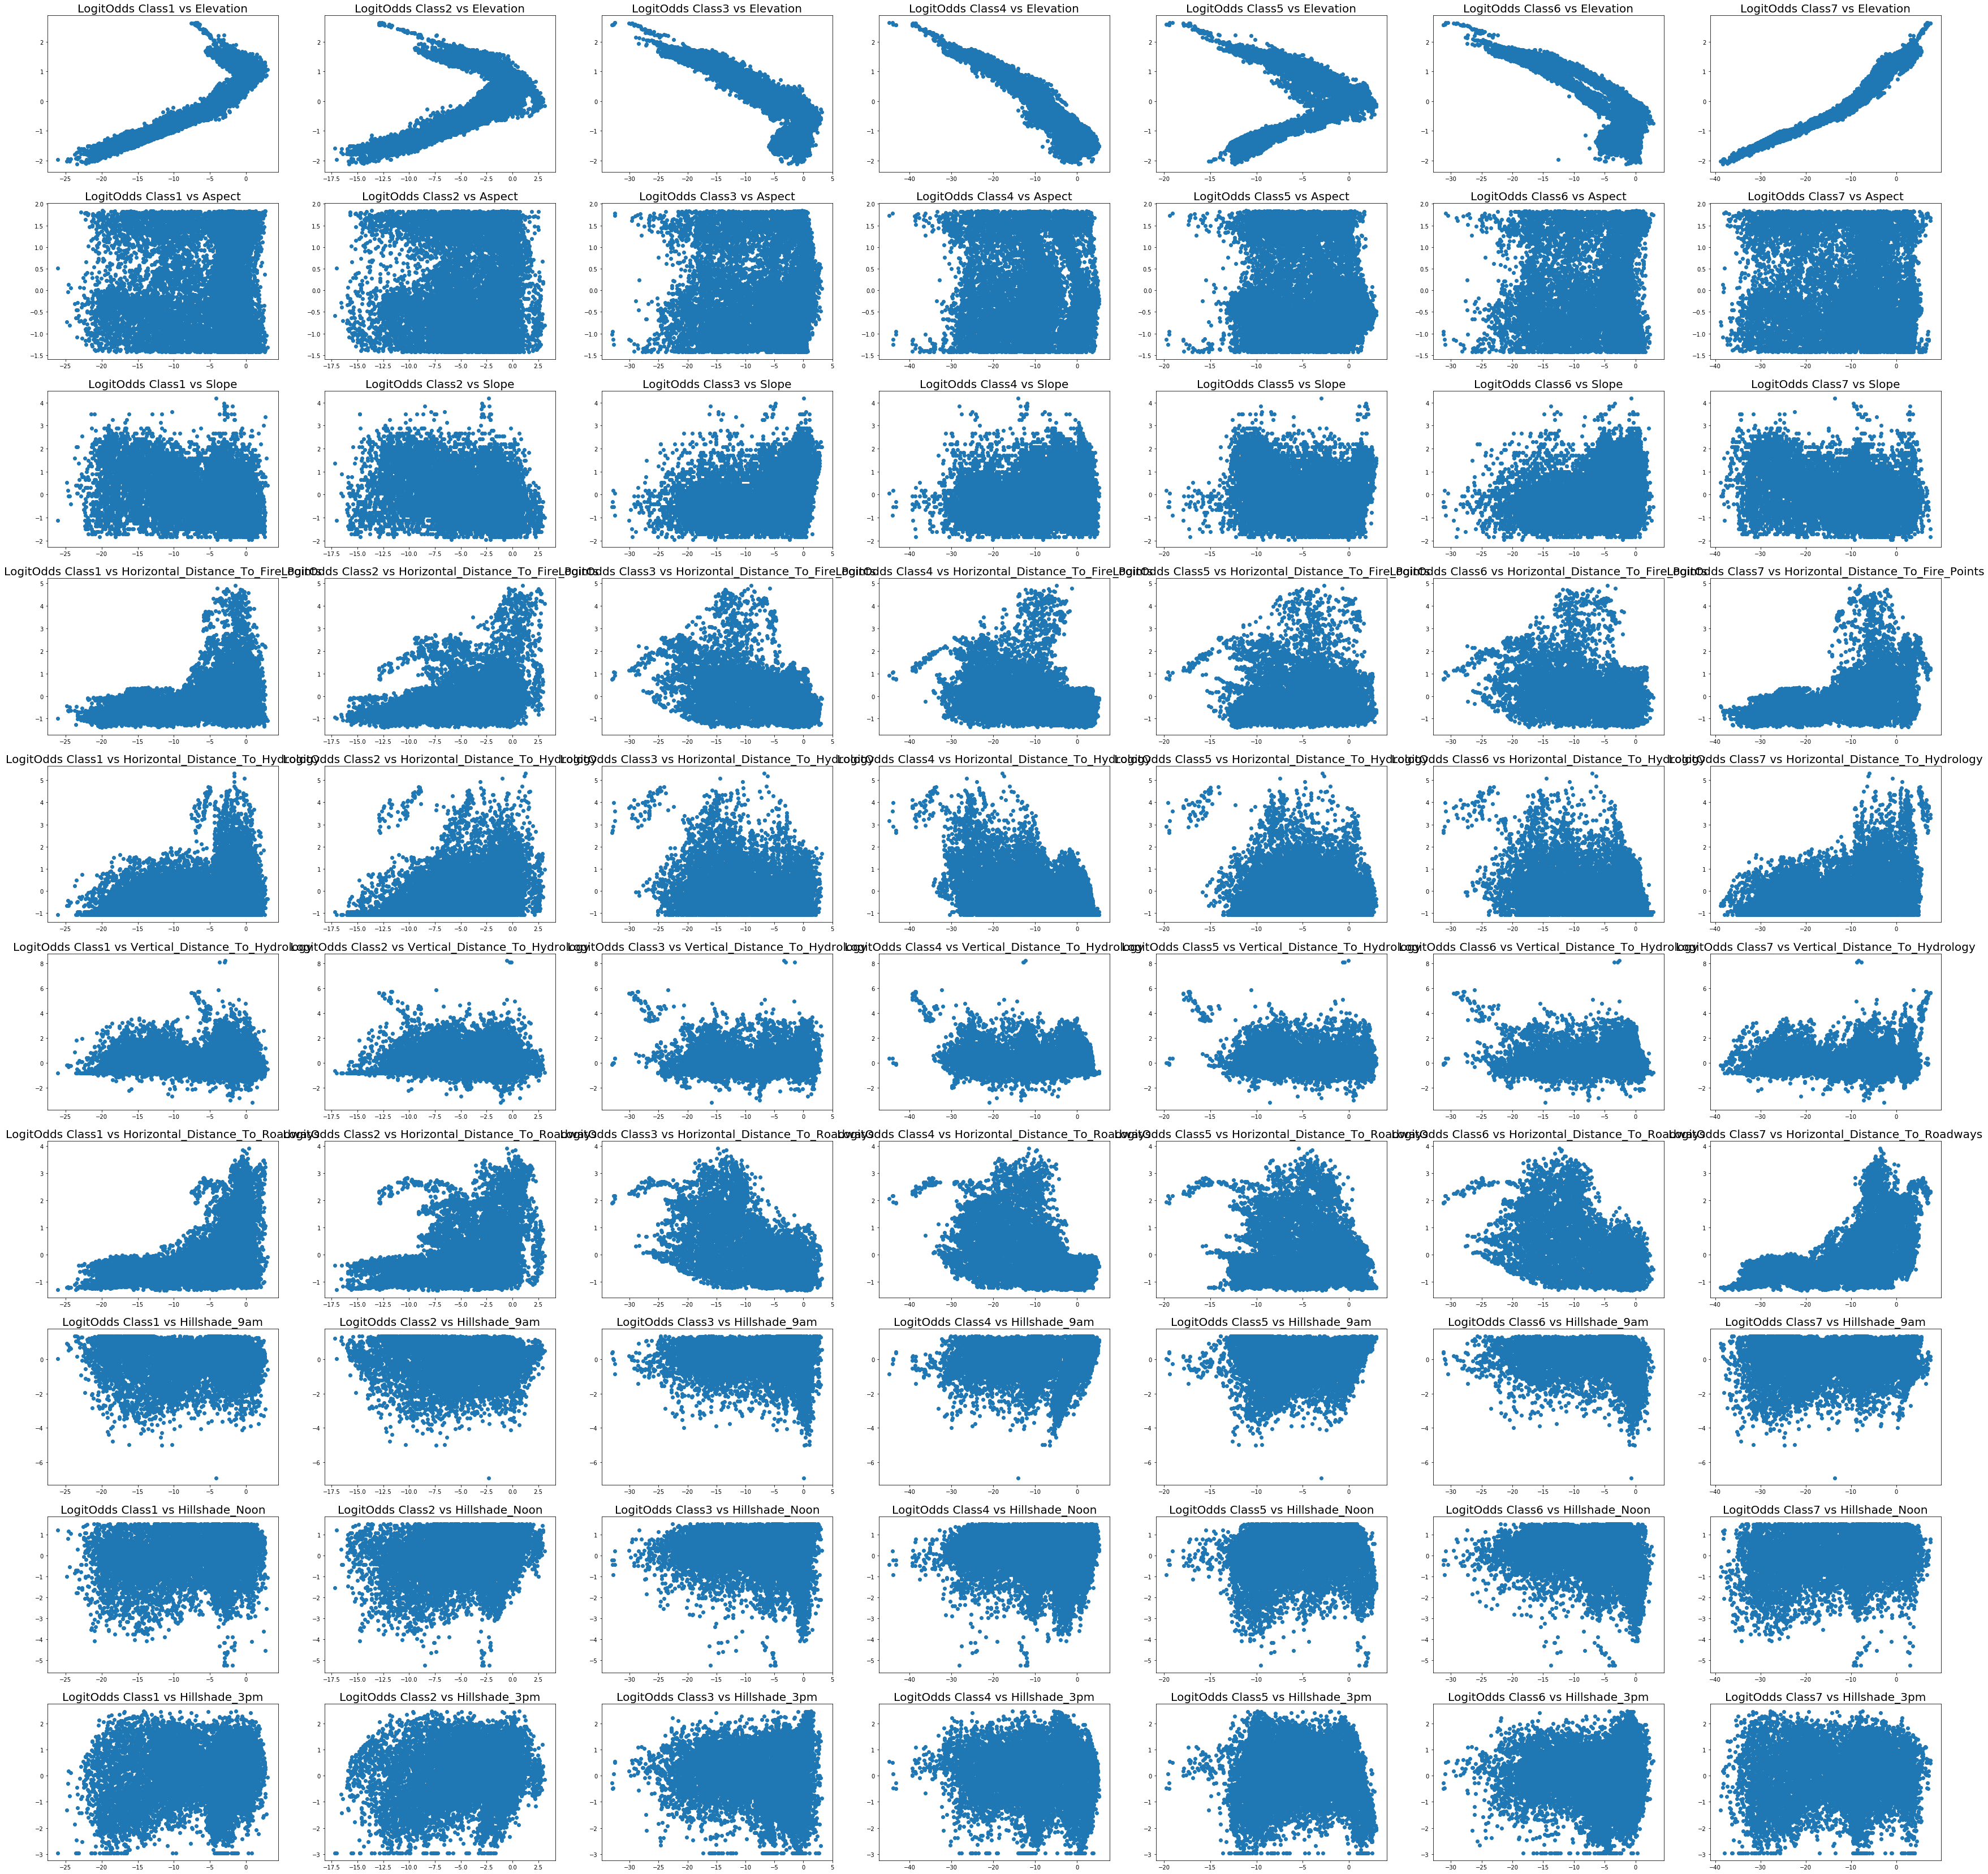



 PART 3 : Best Logistic Regression Model on Test data: 

F1 score on Test data: 0.7017526507393662
Accuracy Ratio on Test data:  0.7017195767195767
Confusion Matrix:
 [[152  26   1   0  14   0  27]
 [ 45 121   6   0  29   5   2]
 [  0   1 123  22  12  62   0]
 [  0   0  27 170   0  15   0]
 [  2  31   4   0 181   9   0]
 [  0   3  62  12   3 126   0]
 [ 31   0   0   0   0   0 188]]
Classification Report:
               precision    recall  f1-score   support

     class 1       0.66      0.69      0.68       220
     class 2       0.66      0.58      0.62       208
     class 3       0.55      0.56      0.56       220
     class 4       0.83      0.80      0.82       212
     class 5       0.76      0.80      0.78       227
     class 6       0.58      0.61      0.60       206
     class 7       0.87      0.86      0.86       219

   micro avg       0.70      0.70      0.70      1512
   macro avg       0.70      0.70      0.70      1512
weighted avg       0.70      0.70      0.70    

In [36]:
############################# LOGISTIC REGRESSION

################## Part 0: Build Logistic Regression Selection Framework

Model_Result_col = ['UsePCA', 'LR-Solver', 'LR-Penalty', 'LR-C','ExecTime(s)', 
                    'ZeroWeight-Coef', 'F1-Score', 'Accuracy-Ratio']
Model_Result = pd.DataFrame(columns = Model_Result_col)


def LR_Model(solver, penalty, c, traind, trainl, devd, devl):
    LR = LogisticRegression(solver=solver, penalty=penalty, C=c, multi_class='multinomial')
    LR.fit(traind, trainl)
    dev_predcit = LR.predict(devd)
    
    zero_wgt = np.sum(LR.coef_ == 0.)
    f1_score = metrics.f1_score(dev_labels, dev_predcit,  average='weighted')
    acc_ratio = metrics.accuracy_score(dev_labels, dev_predcit)
    
    return zero_wgt, f1_score, acc_ratio


def LR_Optimzer(traindata, trainlabel, devdata, devlabel):
    global Model_Result    
    global Model_Result_col
    global LR_params    
    global PCA_params

    for cc in LR_params["C"]:
        for sol_pen in LR_params["solver_penalty"]:
            
            # Original LR result without PCA
            start = time.time()
            LR = LR_Model(solver=sol_pen[0], penalty=sol_pen[1], c=cc, 
                          traind=traindata, trainl=trainlabel,
                          devd=devdata, devl=devlabel)
            end =  time.time()
            timing = end-start
            
            result = dict(zip(Model_Result_col, 
                              ['N/A', sol_pen[0], sol_pen[1], cc, timing, LR[0], LR[1], LR[2]]))
            
            Model_Result[Model_Result.UsePCA==0]['UsePCA'] = np.nan
            
            Model_Result = Model_Result.append(result, ignore_index=True)

            
            
################## Part 1: Train LR model with proposed specs, find the best five model settings

### Scale the data
train_data_lr = train_data.copy(deep = True).astype(dtype = 'float64')
dev_data_lr  = dev_data.copy(deep = True).astype(dtype = 'float64')
test_data_lr  = test_data.copy(deep = True).astype(dtype = 'float64')

scaled_train_data_lr, scaled_dev_data_lr, scaled_test_data_lr = standard_transformation(train_data_lr, 
                                                                                        dev_data_lr, 
                                                                                        test_data_lr)
### List the model specs and select the best one
LR_params = {"C":[0.01, 0.1, 0.5, 1.0, 2.0],  
             "solver_penalty":[['newton-cg', 'l2'], ['lbfgs','l2',], ['sag','l2'], ['saga','l1'],['saga','l2']]}

LR_Optimzer(scaled_train_data_lr, train_labels, scaled_dev_data_lr, dev_labels)

print("PART 1 : The Best Five Logistic Regression Model(according to Accuracy Ratio):","\n")
print(Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(5).to_string()) 



################## Part 2: Best Model on DEV data -  Error Analysis and linearity check

LR_best_Dev = LogisticRegression(solver = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-Solver"].item(),
                        penalty = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-Penalty"].item(),
                        C = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-C"].item(), 
                        multi_class='multinomial')
LR_best_Dev.fit(scaled_train_data_lr, train_labels)
dev_predict = LR_best_Dev.predict(scaled_dev_data_lr)

### Confusion_matrix and classification_report
cf = confusion_matrix(dev_labels, dev_predict)
target_names = ["class "+str(i) for i in range(1,8)]
report = classification_report(dev_labels, dev_predict, target_names=target_names)
print("\n\n", "PART 2.1 : Best Logistic Regression Model on Dev Data - Error Analysis")
print("\nConfusion Matrix:\n",cf)
print("Classification Report:\n",report)

### Linearity check between logit odds and continuous independent variable
logit = np.log(LR_best_Dev.predict_proba(scaled_train_data_lr)/(1-LR_best_Dev.predict_proba(scaled_train_data_lr)))

fig,axs = plt.subplots(nrows=10, ncols=7, figsize=(60,60))

contin_col = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Fire_Points','Horizontal_Distance_To_Hydrology',
              'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways','Hillshade_9am','Hillshade_Noon',
              'Hillshade_3pm']

for row in range(10):
    for col in range(7):
        axs[row][col].scatter(logit[:,col], scaled_train_data_lr[contin_col[row]])
        axs[row][col].set_title("LogitOdds Class" + str(col+1)+ " vs " +contin_col[row], fontsize=20)

print("\n\n", "PART 2.2 : Best Logistic Regression Model on Dev Data - Logit Odds VS Continuous Variable scatter plot")
plt.show()


################## Part 3: Best Model on Test data -  Result and Error Analysis

LR_best_test = LogisticRegression(solver = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-Solver"].item(),
                        penalty = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-Penalty"].item(),
                        C = Model_Result.sort_values('Accuracy-Ratio',ascending = False).head(1)["LR-C"].item(), 
                        multi_class='multinomial')
LR_best_test.fit(scaled_train_data_lr, train_labels)
test_predict = LR_best_test.predict(scaled_test_data_lr)

### Result on Test data
print("\n\n", "PART 3 : Best Logistic Regression Model on Test data:","\n")
print ("F1 score on Test data:", metrics.f1_score(test_labels, test_predict,  average='weighted'))
print ("Accuracy Ratio on Test data: ", metrics.accuracy_score(test_labels, test_predict))

### Confusion_matrix and classification_report
cf = confusion_matrix(test_labels, test_predict)
target_names = ["class "+str(i) for i in range(1,8)]
report = classification_report(test_labels, test_predict, target_names=target_names)
print("Confusion Matrix:\n",cf)
print("Classification Report:\n",report)

**Final Model Result and Conclusion**

* **Best Model**

    In the result of 25 models in the logistic regression experiment, the model with the best performance is: using 'lbfgs' algorithm with L2 penalty and 0.5 as C value, which results in accuracy ratio equals to 0.69 and f1 score is 0.687.


* **Best Model on Dev Data**

   Then we exam the linearity relationship between log odds(based on dev data) and the continuous independent variables for this selected model via scatter plots. The scatter plot shows non-linearity for majority of the continues variables, except for Elevation and Hydrology, which means the rest of independent variables might need transformations, as further improvement to the model. The options to build linear relationship includes using higher power term, fractional polynomials and spline function.

    Error Analysis on DEV data result using the best model shows Class 1, 2, 3 and 6 have relative low precision around 50%~60% which low down the entire accuracy ratio. More specifically, there is high misidentification rate: 
    * Between Class 1 and Class 2: 18% of Class 1 are predicted as Class 2, 25% of Class 2 are predicted as Class 1
    * Between Class 3 and Class 6: 25% of Class 3 are predicted as Class 6, 25% of Class 6 are predicted as Class 3

    Error Analysis shows more EDA between Class 1 vs 2, and Class 3 vs 6 to see how to distinguish them from the features, by colored plotting between each pair on each feature, and then adjust the feature selections in the model to earn a higher accuracy ratio.


* **Best Model on Test Data**

   Use the best model on the test data directly, we get accuracy ratio around 0.70 which is closed to Dev data result. 

   Error Analysis is similar to the Dev data result -- Class 3 and Class 6 have 30% of sample were misidentified to each other. Class 1 and Class 2 have 11% and 22% of samples respectively were misidentified to each other. 


* **Conclusion**

   In general, besides more data exploration between Class 1vs2 and 3vs6 to do more feature engineering, though there are some techniques to improve feature selection and model performance, logistic regression doesn't work well might just simply because: 1) the data is not linearly separable using the provided features, the logit-var plots above mostly show a panel, even not a curve let alone linear. 2) the features provided might not be informative enough to linearly separate the classes (creating interactive features according to correlations or raise power doesn't improve the model performance too much). 
  
  In this scenario, SVM model would be a better option to deal with potential non-linear relationship.

## 4. Support Vector Machine

#### Model Assumption Analysis/Why the model potentially works
Support Vector Machines have remained extremely popular in the aftermath of the rise of neural networks. They are particularly useful in modeling non-linear and linear relationships by choosing a suitable kernel for the problem at hand. SVMs are capable of handling high dimensional features and can be utilized for regression and classification. An SVM creates a set of hyper-planes in high dimensional space which can be used for classification. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (known as functional margin), since in general the larger the margin the lower the generalization error of the classifier.  SVMs utilize "the kernel trick" to take engineered features and engineer them even further to achieve optimal accuracy. As such, this model can be hard to interpret which is worth considering in our model selection process. Cited articles: https://community.alteryx.com/t5/Data-Science-Blog/Why-use-SVM/ba-p/138440, https://scikit-learn.org/stable/modules/svm.html#mathematical-formulation


In [37]:
# Fit SVM Model with raw data

INCLUDE_ALL_HYPERPARAMS = False

# Initialize new data sets for SVM
svm_train_data = train_data.copy(deep=True).astype(dtype = 'float64')        
svm_dev_data = dev_data.copy(deep=True).astype(dtype = 'float64')            
svm_test_data = test_data.copy(deep=True).astype(dtype = 'float64')          

def create_svm_model(training_data, training_labels, score_data, score_labels):
    """
        Function for generating an SVM Model and reporting its accuracy
    """
    
    best_model = {'model': None, 'accuracy': 0.0, 'kernel': '', 'c': 0.0}
    
    # Determines hyper parameter searching for final submission to decrease run time of entire Notebook
    if INCLUDE_ALL_HYPERPARAMS:
        kernels = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
        cs = np.linspace(0.75, 1.25, 10)
    else:
        kernels = ['rbf']
        cs = [1.0]

    for kernel in ['rbf']:
        for c in [1.0]:
            now = datetime.datetime.now()
            print("Starting SVM training with %s + %s @ %s..." % (kernel, c, str(now)))
            svc = SVC(gamma='scale', C=c, kernel=kernel) 
            svc.fit(training_data, training_labels)
            accuracy = svc.score(score_data, score_labels)
            print("SVM Model Accuracy: %s, Elapsed Time: %s" % (str(accuracy), datetime.datetime.now()-now))

            if accuracy > best_model['accuracy']:
                best_model['model'] = svc
                best_model['accuracy'] = accuracy
                best_model['kernel'] = kernel
                best_model['c'] = c

    # Output best model / hyperparameters
    if INCLUDE_ALL_HYPERPARAMS:
        print("Best SVM Model - Accuracy: %s, Kernel: %s, C: %s" % (best_model['accuracy'], best_model['kernel'], best_model['c']))

    return best_model['model']

raw_data_svm = create_svm_model(svm_train_data, train_labels, svm_dev_data, dev_labels)

Starting SVM training with rbf + 1.0 @ 2019-04-08 03:11:46.244130...
SVM Model Accuracy: 0.8611111111111112, Elapsed Time: 0:00:53.203318


In [38]:
# Fit SVM Model with feature engineered data

def remove_uncommon_discrete_columns(dataset):
    """
        Feature Engineering - Function for removing uncommon discrete columns
    """
    new_dataset = dataset.copy(deep=True)
    
    # Remove uncommon soil types
    discrete_counts = []
    for i in range(10, svm_train_data.shape[1]-1):
        column = svm_train_data.columns[i]
        discrete_counts.append(svm_train_data[column].value_counts().iloc[-1])
    
    new_dataset.drop(['Soil_Type8', 'Soil_Type25'], axis=1)
    return new_dataset

svm_train_data_r = remove_uncommon_discrete_columns(svm_train_data)
svm_dev_data_r = remove_uncommon_discrete_columns(svm_dev_data)
svm_test_data_r = remove_uncommon_discrete_columns(svm_test_data)

print("\nAfter Removing Uncommon Soil Types:")
engineered_data_svm = create_svm_model(svm_train_data_r, train_labels, svm_dev_data_r, dev_labels)

def remove_slope_aspect(dataset):
    """
        Feature Engineering - Function for removing Slope and Aspect columns
    """
    
    new_dataset = dataset.copy(deep=True)
    
    # Remove Slope and Aspect columns since partially represented in Elevation
    new_dataset.drop(['Aspect', 'Slope'], axis=1)
    
    return new_dataset
    
svm_train_data_r2 = remove_slope_aspect(svm_train_data_r)
svm_dev_data_r2 = remove_slope_aspect(svm_dev_data_r)
svm_test_data_r2 = remove_slope_aspect(svm_test_data_r)

print("\nAfter Removing Uncommon Soil Types + Slope + Aspect:")
engineered_data_svm = create_svm_model(svm_train_data_r2, train_labels, svm_dev_data_r2, dev_labels)
    
def combine_one_hot_columns(dataset):
    """
        Feature Engineering - Function for combining one hot encoded values
    """
    
    new_dataset = dataset.copy(deep=True)
    
    # Aggregate discrete one hot encoded columns
    wild_names = ['Wilderness_Area' + str(i) for i in range(1, 5)]
    soil_names = ['Soil_Type' + str(i) for i in range(1, 41)]
    combined_binary_names = wild_names + soil_names
    
    # Group Soil one hot encoded values
    new_dataset['Soil_Cat'] = 0
    for i, name in enumerate(soil_names, 1):
        new_dataset.loc[new_dataset[name] == 1, 'Soil_Cat'] = i
    
    # Group Wilderness one hot encoded values
    new_dataset['Wilderness_Cat'] = 0
    for i, name in enumerate(wild_names, 1):
        new_dataset.loc[new_dataset[name] == 1, 'Wilderness_Cat'] = i
    
    # Remove one hot encoded columns
    for column in combined_binary_names:
        new_dataset = new_dataset.drop(column, axis = 1)

    return new_dataset


svm_train_data_c = combine_one_hot_columns(svm_train_data)
svm_dev_data_c = combine_one_hot_columns(svm_dev_data)

print("\nAfter Combining:")
engineered_data_svm = create_svm_model(svm_train_data_c, train_labels, svm_dev_data_c, dev_labels)

svm_train_data_n, svm_dev_data_n, svm_test_data_n = standard_transformation(svm_train_data, svm_dev_data, svm_test_data)

print("\nAfter Standard Scaler:")
engineered_data_svm = create_svm_model(svm_train_data_n, train_labels, svm_dev_data_n, dev_labels)


After Removing Uncommon Soil Types:
Starting SVM training with rbf + 1.0 @ 2019-04-08 03:12:58.481356...
SVM Model Accuracy: 0.8611111111111112, Elapsed Time: 0:00:42.754577

After Removing Uncommon Soil Types + Slope + Aspect:
Starting SVM training with rbf + 1.0 @ 2019-04-08 03:13:41.245538...
SVM Model Accuracy: 0.8611111111111112, Elapsed Time: 0:00:51.175261

After Combining:
Starting SVM training with rbf + 1.0 @ 2019-04-08 03:14:33.074239...
SVM Model Accuracy: 0.8366402116402116, Elapsed Time: 0:00:25.795167

After Standard Scaler:
Starting SVM training with rbf + 1.0 @ 2019-04-08 03:14:58.912804...
SVM Model Accuracy: 0.7427248677248677, Elapsed Time: 0:00:11.965973


In [39]:
#Adaboost on best SVM + Features thus far
estimators = [40, 50, 60]
learning_rates = [.95, 1.0, 1.05]
if INCLUDE_ALL_HYPERPARAMS:
    print(adaboost_optimizer(raw_data_svm, estimators, learning_rates, svm_train_data, svm_dev_data))
    
#This takes too long to run (Several Hours). First run gives accuracy of 26.58% for 40 estimators.  
#We include the code here, but this version will not run.  Please see results analysis below.

In [40]:
# Best SVM Model and Features accuracy on test data
print("Best SVM Model - RBF Kernel, C=1.0, Removed Columns Dataset:")
engineered_data_svm = create_svm_model(svm_train_data_r2, train_labels, svm_test_data_r2, test_labels)

print("Classification Report")
print(classification_report(test_labels, engineered_data_svm.predict(svm_test_data_r2)))

print("Confusion Matrix")
print(confusion_matrix(test_labels, engineered_data_svm.predict(svm_test_data_r2)))

Best SVM Model - RBF Kernel, C=1.0, Removed Columns Dataset:
Starting SVM training with rbf + 1.0 @ 2019-04-08 03:15:40.045657...
SVM Model Accuracy: 0.8538359788359788, Elapsed Time: 0:00:39.033815
Classification Report
              precision    recall  f1-score   support

           1       0.78      0.72      0.75       220
           2       0.72      0.72      0.72       208
           3       0.82      0.79      0.81       220
           4       0.94      0.97      0.96       212
           5       0.92      0.95      0.93       227
           6       0.83      0.88      0.86       206
           7       0.94      0.95      0.94       219

   micro avg       0.85      0.85      0.85      1512
   macro avg       0.85      0.85      0.85      1512
weighted avg       0.85      0.85      0.85      1512

Confusion Matrix
[[158  43   0   0   5   0  14]
 [ 35 149   9   0   9   6   0]
 [  0   7 174  10   2  27   0]
 [  0   0   4 206   0   2   0]
 [  1   4   6   0 215   1   0]
 [  0   0 

#### Support Vector Machines Results
We were able to achieve 85.38% accuracy with a Support Vector Machine using a Radial Basis Function Kernel and C regularization value of 1.0.  For visibility into model training timing and accuracies, we elected to not use GridSearchCV and instead use several loops over the Hyper Parameters.  A constant INCLUDE_ALL_HYPERPARAMS is set to False for the final report to avoid large model training times, especially for any SVM models being trained with a Poly Kernel (e.g. 6+ hours).  Several attempts at feature engineering were made to improve the accuracy/performance of our SVM Model.  The most successful feature engineering changes were removing low frequency (e.g. Soil Type columns) and highly correlated (e.g. Aspect + Slope) columns from the dataset.  Additional feature engineering that yielded decreased accuracy were combining one hot encoded columns into a single discrete column and applying a standard scaler transformation.  Finally, we applied AdaBoost to our best SVM model to try leveraging an ensemble approach to improve our accuracy.  Unfortunately, this AdaBoosted model ultimately yielded a final accuracy of 26.58%.

**Improving SVM Results**

As seen in the classification report and confusion matrix, this model lacked primarily in predicting cover types 1 and 2. Notably, cover type 1 and 2 seem to be misclassified as each other in the majority of the error cases. We were hoping that AdaBoost would help with addressing the most commonly misclassified cover types, but the AdaBoosted SVM had lack luster results. The AdaBoosted SVM yielded poor results with a small list of values for estimators and learning rates, but likely would have had better accuracy with a larger number of estimators. Additionally, the best SVM Model results were obtained without any analysis using a chi-square test which can be used for analyzing discrete variable relationships. This may have been useful for determining which additional discrete columns were not useful for modeling. Finally, applying further principle component analysis may have yielded faster model training times, so higher thresholds for boosting estimators and more iterations of hyper parameters could have been attempted in less time.  

## 5. Decision Trees, Random Forest

For replicability of the results, we used random_state = 0 for all of our Decision Tree and Random Forest models.

In [41]:
# deepcopy dev_data, test_data
dt_train = copy.deepcopy(train_data)
dt_dev = copy.deepcopy(dev_data)
dt_test = copy.deepcopy(test_data)

# keeping track of experiments and accuracies

dt_accuracies = []
dt_experiments = []
rf_accuracies = []
rf_experiments = []


#Other Functions
def model_performance(model, train_data, train_labels, dev_data, dev_labels, metrics = True):
    
    """
    Takes a custom model and fits the train data and labels
    Prints classification report, confusion, matrix, and accuracy
    Returns accuracy
    """
    
    model.fit(train_data, train_labels)
    dtree_pred = model.predict(dev_data)
    
    if metrics == True:
        print(classification_report(dev_labels, dtree_pred))
        print(confusion_matrix(dev_labels, dtree_pred))
        print("\naccuracy:", np.mean(dev_labels == dtree_pred))
    
    return np.mean(dev_labels == dtree_pred)

def importance_table(model, data, sort = True):
    """ By default, create dataframe (descending sort) of feature importances of decision tree or random forest model """
    
    table = pd.DataFrame({'importance':model.feature_importances_}, index = data.columns)
    
    if sort == True:
        return table.sort_values(by = 'importance', axis = 0, ascending = False)
    elif sort == False:
        return table

### Decision Trees

#### Basic Decision Tree Model

First, we established a baseline with a simple Decision Tree model, changing the criterion to entropy. This resulted in 79.23% accuracy on the development data. In examining feature importance of the baseline model, we saw that Elevation, Horizontal Distance to Roadways, Horizontal Distance to Fire Points, Horizontal Distance to Hydrology were ranked the highest.

In [42]:
# specifying entropy, default is gini
dtree1 = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_accuracies.append(model_performance(dtree1, dt_train, train_labels, dt_dev, dev_labels))
dt_experiments.append('Basic Decision Tree')
importance_table(dtree1, dt_train, sort = True)

              precision    recall  f1-score   support

           1       0.68      0.63      0.66       216
           2       0.65      0.58      0.62       226
           3       0.76      0.73      0.75       203
           4       0.92      0.95      0.93       243
           5       0.84      0.93      0.88       198
           6       0.78      0.78      0.78       222
           7       0.87      0.95      0.91       204

   micro avg       0.79      0.79      0.79      1512
   macro avg       0.79      0.79      0.79      1512
weighted avg       0.79      0.79      0.79      1512

[[137  50   1   0   4   1  23]
 [ 54 132   3   1  24   7   5]
 [  0   4 149   9   4  37   0]
 [  0   0  10 230   0   3   0]
 [  2   7   3   0 184   1   1]
 [  0   8  30   9   2 173   0]
 [  8   1   0   0   2   0 193]]

accuracy: 0.7923280423280423


importance
Elevation                             0.551508
Horizontal_Distance_To_Roadways       0.074367
Horizontal_Distance_To_Fire_Points    0.060600
Horizontal_Distance_To_Hydrology      0.053318
Hillshade_9am                         0.046529
Vertical_Distance_To_Hydrology        0.026441
Hillshade_Noon                        0.026102
Aspect                                0.024384
Wilderness_Area1                      0.022788
Hillshade_3pm                         0.022064
Slope                                 0.015115
Soil_Type3                            0.010435
Wilderness_Area3                      0.009432
Soil_Type10                           0.008871
Soil_Type4                            0.005386
Soil_Type39                           0.004224
Soil_Type29                           0.003109
Soil_Type2                            0.003102
Soil_Type33                           0.003051
Soil_Type23                           0.002960
Soil_Type38                           0.002266
Soil_Type32                           0.002256
Soil_Type12                           0.002186
Soil_Type13                           0.002002
Soil_Type17                           0.001883
Soil_Type11                           0.001746
Soil_Type20                           0.001742
Soil_Type30                           0.001736
Soil_Type6                            0.001582
Soil_Type40                           0.001330
Soil_Type31                           0.001189
Soil_Type24                           0.001127
Soil_Type22                           0.001089
Soil_Type35                           0.001025
Soil_Type1                            0.000594
Wilderness_Area4                      0.000437
Soil_Type16                           0.000377
Soil_Type14                           0.000369
Soil_Type27                           0.000319
Soil_Type26                           0.000248
Soil_Type21                           0.000171
Wilderness_Area2                      0.000148
Soil_Type18                           0.000142
Soil_Type9                            0.000138
Soil_Type5                            0.000115
Soil_Type25                           0.000000
Soil_Type28                           0.000000
Soil_Type7                            0.000000
Soil_Type34                           0.000000
Soil_Type15                           0.000000
Soil_Type36                           0.000000
Soil_Type37                           0.000000
Soil_Type19                           0.000000
Soil_Type8                            0.000000

#### Decision Tree: Optimizing max_depth parameter

After running the baseline Decision Tree model, we sought to optimize parameters that could improve performance and reduce overfitting. First, we looked at the max_depth parameter, which controls the maximum depth of the tree that is generated. Through GridSearchCV, we found that 24 is the optimal max_depth, which "prunes" our Decision Tree by 30 levels. In using a model with max_depth = 24, we saw slight improvement in accuracy from 79.23% to 79.70%. At the same time, the feature importances ranking looked similar to that of the baseline model.

#### Decision Tree: Optimizing max_features

Next, we examined the max_features parameter, which refers to the maximum number of features to consider when looking for the best split. We found that 40 features was the optimal setting and this yielded an accuracy of 79.56%. Overall, in terms of accuracy, precision, recall, and F-1 scores, this version was comparable to the model with max_depth = 24. However, there are differences in the confusion matrix that suggest this version may not be the most optimal. For example, more cover types 2 and 6 examples are mistake as cover type 1 than in the model that optimized for max_depth. Additionally, this model has more nodes than the latter, so we opted for the more parsimonious model given that the comparable performance.

In [43]:
# this can take 2-3 mins to run
dtpl = Pipeline([('classifier', dtree1)])

param_grid = dict(classifier__max_depth = [n for n in range(10, (dt_train.shape[1] + 1))])

dtgs = GridSearchCV(dtpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
print(dtgs.best_params_)

dtree2 = DecisionTreeClassifier(criterion = 'entropy', max_depth = 24, random_state = 0)
dt_accuracies.append(model_performance(dtree2, dt_train, train_labels, dt_dev, dev_labels))
dt_experiments.append('Decision Tree with max_depth = 24')

param_grid = dict(classifier__max_features = [n for n in range(10, (dt_train.shape[1] + 1))])

dtgs = GridSearchCV(dtpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
print(dtgs.best_params_)

dtree3 = DecisionTreeClassifier(criterion = 'entropy', max_features = 40, random_state = 0)
dt_accuracies.append(model_performance(dtree3, dt_train, train_labels, dt_dev, dev_labels))
dt_experiments.append('Decision Tree with max_features = 40')

{'classifier__max_depth': 24}
              precision    recall  f1-score   support

           1       0.69      0.65      0.67       216
           2       0.68      0.60      0.63       226
           3       0.76      0.74      0.75       203
           4       0.92      0.95      0.93       243
           5       0.84      0.93      0.88       198
           6       0.78      0.78      0.78       222
           7       0.87      0.95      0.91       204

   micro avg       0.80      0.80      0.80      1512
   macro avg       0.79      0.80      0.79      1512
weighted avg       0.79      0.80      0.79      1512

[[140  47   1   0   4   1  23]
 [ 49 135   4   1  24   8   5]
 [  0   3 150   9   4  37   0]
 [  0   0  10 230   0   3   0]
 [  3   6   3   0 184   1   1]
 [  0   8  30   9   2 173   0]
 [ 10   1   0   0   0   0 193]]

accuracy: 0.796957671957672
{'classifier__max_features': 40}
              precision    recall  f1-score   support

           1       0.67      0.66     

#### Decision Tree: Optimizing min_samples_split & min_samples_leaf

Next, we respectively optimized for min_samples_split, which refers to the minimum number of samples to split an internal node, and  min_samples_leaf, which refers to the minimum number of samples to be in a leaf node. From this optimizations, we found that percentages closest to 0 for both min_samples_split and min_samples_leaf achieved the best results. For example, min_samples_split to 0.01 pruned the tree back too far so accuracy was reduced to 74.21%. This version had only 411 nodes compared to approximately 3233 for the baseline and optimized max_depth trees respectively. With min_samples_split = 0.001, the accuracy was still lower than that of the baseline model. Similarly, with min_samples_leaf = 0.001, the accuracy achieved was 76.85%.

In [44]:
param_grid = dict(classifier__min_samples_split = [n for n in np.arange(0.001, 0.01, 0.01)])

dtgs = GridSearchCV(dtpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
print(dtgs.best_params_)

dtree4 = DecisionTreeClassifier(criterion = 'entropy', min_samples_split = 0.001, random_state = 0)
dt_accuracies.append(model_performance(dtree4, dt_train, train_labels, dt_dev, dev_labels, metrics = False))
dt_experiments.append('Decision Tree with min_samples_split = 0.001')

param_grid = dict(classifier__min_samples_leaf = [n for n in np.arange(0.001, 0.01, 0.002)])

dtgs = GridSearchCV(dtpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
print(dtgs.best_params_)

dtree5 = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 0.001, random_state = 0)
dt_accuracies.append(model_performance(dtree5, dt_train, train_labels, dt_dev, dev_labels, metrics = False))
dt_experiments.append('Decision Tree with min_samples_leaf = 0.001')

{'classifier__min_samples_split': 0.001}
{'classifier__min_samples_leaf': 0.001}


In [45]:
# Best Decision Tree
best_dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 24, random_state = 0)

#### Decision Tree: Error Analysis

From the confusion matrix, we saw that the model has the most difficulty classifying cover types 1, 2, 3, and 6, with cover types 1 and 2 having the lowest F-1 scores. This is expected since we saw from our EDA that some cover types were not as clearly delineated, especially in regards to the Elevation feature. Indeed, the Decision Tree feature importances confirmed that Elevation has the highest importance out of all the features, which may explain the misclassification of these particular cover types.

### Ensemble Methods: Adaboost & Random Forest

#### Adaboost

After the initial modeling with Decision Tree, we also tested ensemble methods such as Adaboost and Random Forest. With our best Decision Tree model, we were able to increase accuracy to 80.69% with AdaBoost using as few as 10 estimators with a learning rate of 0.10. On the other hand, we saw a larger increase in accuracy by optimizing Random Forest, which led us to pursue optimization, feature selection, and feature engineering to improve that model.

In [46]:
learning_rates = [0.01, 0.01, 0.1, 1, 1.5]
estimators = [n for n in range(10, 100, 10)]

# show top 10
adaboost_optimzer(best_dt, estimators, learning_rates, dt_train, dt_dev)[:10]

Maximum Number of Estimators  Learning Rates  Accuracy
22                            50            0.10  0.806878
37                            80            0.10  0.806878
17                            40            0.10  0.806878
27                            60            0.10  0.806878
12                            30            0.10  0.806878
7                             20            0.10  0.806878
32                            70            0.10  0.806878
42                            90            0.10  0.806878
2                             10            0.10  0.806878
40                            90            0.01  0.798280

#### Random Forest

#### Random Forest: Optimizing n_estimators

To get a sense of the appropriate parameter grid, we initially tried 10, 1000, and 1500 trees respectively to establish a baseline and determine an appropriate range for the parameter grid. With 10 trees, the model had an accuracy of approximately 82%. The models with 1000 and 1500 trees respectively had accuracies around 86%. Given that the higher the number of trees used in Random Forest, the longer it takes to train, we chose to search for an optimal number of estimators below 1000. After running GridSearchCV, we found that the optimal number of trees is 600. 

We also examined the feature importances from the Random Forest model and compared them to that of our Decision Tree model. The feature importance of Elevation was reduced from approximately 0.55 to 0.26 and we saw that soil types that previously had no importance gained some in this model. Perhaps, this suggests that while Elevation is important, it is overemphasized in our Decision Tree model. Additionally, the importance of Wilderness_Area4 rose to 0.07 whereas in the Decision Tree Model, its importance was less than 0.001.

#### Random Forest: Optimizing for max_depth

Given the results of our parameter optimization for Decision Trees, we chose to focus on optimizing for max_depth for our Random Forest model. Having a lower max_depth may also help decrease the speed of training given the optimal number of estimators. The optimal max_depth for Random Forest was found to be 35, which is a bit higher than that of the Decision Tree model. The accuracy of the model with max_depth = 35 is 86.18%--only had a slight improvement in accuracy compared to the baseline Random Forest model, which was 86.11%. 

In [47]:
# note: gridsearch can take 10-15 mins to run
#rfpl = Pipeline([('classifier', RandomForestClassifier(criterion = 'entropy', random_state = 0))])

#param_grid = dict(classifier__n_estimators = [n for n in range(100, 1000, 100)])

#rfgs = GridSearchCV(rfpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
#print(rfgs.best_params_)

rfc1 = RandomForestClassifier(n_estimators = 600, criterion = 'entropy', random_state = 0)
rf_accuracies.append(model_performance(rfc1, dt_train, train_labels, dt_dev, dev_labels))
rf_experiments.append('Random Forest n_estimators = 600')
importance_table(rfc1, dt_train, sort = True)

              precision    recall  f1-score   support

           1       0.76      0.74      0.75       216
           2       0.78      0.69      0.73       226
           3       0.87      0.83      0.85       203
           4       0.92      0.98      0.95       243
           5       0.87      0.97      0.92       198
           6       0.86      0.85      0.86       222
           7       0.94      0.97      0.95       204

   micro avg       0.86      0.86      0.86      1512
   macro avg       0.86      0.86      0.86      1512
weighted avg       0.86      0.86      0.86      1512

[[160  39   0   0   6   0  11]
 [ 44 156   1   0  18   5   2]
 [  0   0 168  11   3  21   0]
 [  0   0   2 238   0   3   0]
 [  0   2   1   0 193   2   0]
 [  0   2  21   9   1 189   0]
 [  6   0   0   0   0   0 198]]

accuracy: 0.8611111111111112


importance
Elevation                             0.262381
Horizontal_Distance_To_Roadways       0.088981
Wilderness_Area4                      0.078875
Horizontal_Distance_To_Fire_Points    0.064422
Horizontal_Distance_To_Hydrology      0.049385
Vertical_Distance_To_Hydrology        0.043686
Hillshade_9am                         0.041909
Aspect                                0.039704
Hillshade_3pm                         0.036511
Hillshade_Noon                        0.036418
Slope                                 0.030812
Wilderness_Area1                      0.029382
Wilderness_Area3                      0.026133
Soil_Type10                           0.025632
Soil_Type38                           0.017212
Soil_Type39                           0.016430
Soil_Type3                            0.015170
Soil_Type4                            0.012071
Soil_Type40                           0.008490
Soil_Type30                           0.007071
Soil_Type29                           0.006430
Soil_Type2                            0.006361
Soil_Type13                           0.005692
Soil_Type17                           0.005355
Soil_Type23                           0.005036
Soil_Type32                           0.004890
Wilderness_Area2                      0.004750
Soil_Type22                           0.004287
Soil_Type33                           0.003701
Soil_Type11                           0.003300
Soil_Type12                           0.003208
Soil_Type6                            0.002867
Soil_Type31                           0.002228
Soil_Type24                           0.001988
Soil_Type35                           0.001681
Soil_Type20                           0.001383
Soil_Type1                            0.001343
Soil_Type5                            0.000986
Soil_Type16                           0.000794
Soil_Type18                           0.000728
Soil_Type14                           0.000613
Soil_Type37                           0.000382
Soil_Type26                           0.000375
Soil_Type19                           0.000273
Soil_Type34                           0.000184
Soil_Type21                           0.000138
Soil_Type27                           0.000116
Soil_Type28                           0.000082
Soil_Type36                           0.000072
Soil_Type9                            0.000070
Soil_Type25                           0.000014
Soil_Type7                            0.000000
Soil_Type8                            0.000000
Soil_Type15                           0.000000

In [48]:
# gridsearch can take 7-10 mins to run
#rfpl = Pipeline([('classifier', rfc1)])
#param_grid = dict(classifier__max_depth = [n for n in range(10, 55, 5)])

#rfgs2 = GridSearchCV(rfpl, param_grid, iid = True, refit = True, cv=5, return_train_score=True).fit(dt_train, train_labels)
#print(rfgs2.best_params_)

rfc2 = RandomForestClassifier(n_estimators = 600, max_depth = 35, criterion = 'entropy', random_state = 0)
rf_accuracies.append(model_performance(rfc2, dt_train, train_labels, dt_dev, dev_labels))
rf_experiments.append('Random Forest n_estimators = 600, max_depth = 35')

              precision    recall  f1-score   support

           1       0.76      0.74      0.75       216
           2       0.79      0.69      0.74       226
           3       0.87      0.83      0.85       203
           4       0.92      0.98      0.95       243
           5       0.87      0.97      0.92       198
           6       0.86      0.86      0.86       222
           7       0.94      0.97      0.95       204

   micro avg       0.86      0.86      0.86      1512
   macro avg       0.86      0.86      0.86      1512
weighted avg       0.86      0.86      0.86      1512

[[160  39   0   0   6   0  11]
 [ 44 156   1   0  18   5   2]
 [  0   0 168  11   3  21   0]
 [  0   0   2 238   0   3   0]
 [  0   2   1   0 193   2   0]
 [  0   1  21   9   1 190   0]
 [  6   0   0   0   0   0 198]]

accuracy: 0.8617724867724867


In [49]:
# Best Random Forest

best_rf = RandomForestClassifier(criterion = 'entropy', n_estimators = 600, max_depth = 35,  random_state = 0)

#### Error Analysis

Ultimately, the two versions of the Random Forest models had similar confusion matrices, suggesting comparable results in classification. However, there were marked differences between how well the Random Forest model classifies versus the Decision Tree. Most notably, less cover type 1 examples were confused for cover type 7 and less cover type 3 examples were confused for cover type 6. The model also achieved over 97% accuracy for cover types 4, 5, and 7. Cover type 1 and 2 examples remained the most difficult to differentiate from each other, but the Random Forest model performed much better than our best Decision Tree model in that capacity as well.

### Feature Selection

#### Feature Selection: Dropping Slope and Aspect in Dataset

The Decision Tree model (optimized for max_depth) trained on the dataset excluding slope and aspect had an accuracy of 79.43%, which is not much smaller than that of the Decision Model trained on the full dataset. However, in comparing the confusion matrices, the model trained with the smaller dataset confused the classification of cover types 1 and 2 more than the model with the full dataset. However, in terms of the Random Forest model (optimized for max_depth), we found slightly better accuracy at 86.84% training with this smaller dataset. Below, we highlight the results from the Random Forest model.

#### Feature Selection: Dropping the soil types that have little to no importance

In examining feature importances of the Decision Tee and Random Forest models, we saw that some soil types continued to show little or no importance. We examined the effect of dropping those specific soil types and retraining on this smaller dataset and saw improvements for both models. For the Decision Tree model, the accuracy increased to 80.29% and for the Random Forest model, the accuracy increased to 86.04%. Below, we highlight the results for retraining on the Random Forest model.

#### Feature Selection: Dropping Slope, Aspect, & Unimportant Soil Types

Based on the results of the previous experiments, we examined the impact of removing the combination of these columns from the dataset and retraining both types of models. This resulted in 79.43% accuracy for the Decision Tree model. On the other hand, we saw an increase in accuracy for the Random Forest model at 87.03%. The confusion matrix also shows a slight improvement in classification for cover types 1, 2, 3, and 6.

In [50]:
# removing from train
drop_col1 = ['Slope', 'Aspect']
dt_train2 = dt_train.drop(drop_col1, axis = 1)
dt_dev2 = dt_dev.drop(drop_col1, axis = 1)

# using GridSearch, we found max_depth = 20 to be optimal
dt_accuracies.append(model_performance(best_dt, dt_train2, train_labels, dt_dev2, dev_labels, metrics = False))
dt_experiments.append('Feature Selection: No Slope, Aspect')
# using GridSearch, we found max_depth = 40 to be optimal
rf_accuracies.append(model_performance(best_rf, dt_train2, train_labels, dt_dev2, dev_labels, metrics = False))
rf_experiments.append('Feature Selection: No Slope, Aspect')

# this list is from the feature importances table from the best random forest
rf_table = importance_table(best_rf.fit(dt_train, train_labels), dt_train, sort = True)
drop_col2 = rf_table.index[rf_table['importance'] < 0.0001].tolist()

dt_train3 = dt_train.drop(drop_col2, axis = 1)
dt_dev3 = dt_dev.drop(drop_col2, axis = 1)

dt_accuracies.append(model_performance(best_dt, dt_train3, train_labels, dt_dev3, dev_labels, metrics = False))
dt_experiments.append('Feature Selection: No Unimporant Soil Types')
rf_accuracies.append(model_performance(best_rf, dt_train3, train_labels, dt_dev3, dev_labels, metrics = False))
rf_experiments.append('Feature Selection: No Unimporant Soil Types')

drop_col3 = drop_col1 + drop_col2
dt_train4 = dt_train.drop(drop_col3, axis = 1)
dt_dev4 = dt_dev.drop(drop_col3, axis = 1)

dt_accuracies.append(model_performance(best_dt, dt_train4, train_labels, dt_dev4, dev_labels, metrics = False))
dt_experiments.append('Feature Selection: No Slope, Aspect, & Unimportant Soil Types')
rf_accuracies.append(model_performance(best_rf, dt_train4, train_labels, dt_dev4, dev_labels))
rf_experiments.append('Feature Selection: No Slope, Aspect, & Unimportant Soil Types')

              precision    recall  f1-score   support

           1       0.78      0.75      0.77       216
           2       0.79      0.70      0.74       226
           3       0.88      0.84      0.86       203
           4       0.93      0.98      0.95       243
           5       0.89      0.97      0.93       198
           6       0.86      0.86      0.86       222
           7       0.94      0.98      0.96       204

   micro avg       0.87      0.87      0.87      1512
   macro avg       0.87      0.87      0.87      1512
weighted avg       0.87      0.87      0.87      1512

[[163  39   0   0   5   0   9]
 [ 42 159   2   0  16   4   3]
 [  0   0 171  10   1  21   0]
 [  0   0   1 239   0   3   0]
 [  0   2   1   0 193   2   0]
 [  0   1  19   9   1 192   0]
 [  5   0   0   0   0   0 199]]

accuracy: 0.8703703703703703


#### Feature Engineering: New Soil Type Features

By far, the soil types contribute the most to the high dimensionality of the train dataset since there are 40 types. From experimenting with feature selection, we know that there is some information value to the soil types, but there may be a way to reduce the dimensions without loss of information. First, we ran our best Random Forest model on just the soil types as a way to prioritize the importance of the soil types. 

The original problem description also came with information on each soil type. We did a basic analysis of the words/terms in these descriptions to create new one-hot encoded features such as stony, rubbly, Leighcan, Catamount, complex, etc. These denoted soil qualities and common families they share. As we have seen with other models, some soil types have little to no importance, so we excluded these from the analysis in further efforts to keep the number of dimensions lower. Through this, we were able to describe the soil types with 33 columns compared to the original 40, reducing the overall features to 47 from 54. We also tested a version of new features created from just the most important soil types, which only required 23 columns to describe the soil types. In that version, we only used 37 features to train compared to the original 54. Both versions had comparable performance to the original dataset with the original performing slightly better. 

In [51]:
# create datasets with just the soil types
dt_train_justsoil = dt_train.drop(list(train_data.columns[:14]), axis = 1)
dt_dev_justsoil = dt_dev.drop(list(dev_data.columns[:14]), axis = 1)

best_rf_soils = RandomForestClassifier(n_estimators = 600, max_depth = 35, criterion = 'entropy', random_state = 0).fit(dt_train_justsoil, train_labels)
# get the feature importance of the soil types
rf_importance_soil = importance_table(best_rf_soils, dt_train_justsoil, sort = True)
# we will use the mean of the feature importance to set the threshold of which soil types are important
importance_threshold = np.mean(rf_importance_soil['importance'])

# get the unimportant soil types
remove_soils = rf_importance_soil.index[rf_importance_soil['importance'] < 0.001].tolist()
remove_soil_ind = []
# get the indices for these soil types
for soil in remove_soils:
    remove_soil_ind.append(int(soil.split('Soil_Type')[1]) - 1)

# get the most important soil types
priority_soils = rf_importance_soil.index[rf_importance_soil['importance'] > importance_threshold].tolist()
priority_soil_ind = []
# get the indices for these soil types
for soil in priority_soils:
    priority_soil_ind.append(int(soil.split('Soil_Type')[1]) - 1)

# read in the soil type info
soils_analysis = pd.read_csv('soil_types.csv', header = None)
# drop the unimportant soil types so they won't be included in the description analysis
soils_analysis_all = soils_analysis.drop(remove_soil_ind, axis = 0)
# get only the most important soil types
soils_analysis_priority = soils_analysis.iloc[priority_soil_ind]

In [52]:
def get_terms(soil_desc):
    """ Takes in list of soil descriptions and builds a dict of word and word count """
    terms_dict = {}

    for soil in soil_desc[0]:
        soil = re.sub(r'[^\w\s]','', soil)
        words = soil.split()

        for word in words:
            if word in [str(n) for n in range(1, 41)]:
                continue
            elif word in terms_dict:
                terms_dict[word] += 1
            else:
                terms_dict[word] = 1
    
    return terms_dict

def filter_terms(terms_dict):
    """ Takes in the terms dictionary and remove unnecessary words and add in common two word terms """
    
    terms = list(terms_dict.keys())
    remove_terms = ['family', 'Rock', 'outcrop', 'extremely', 'families', 'very', 'land', 'till', 'substratum']

    for term in remove_terms:
        try:
            terms.remove(term)
        except:
            continue
    # add back in two word terms
    terms = terms + ['Rock land', 'Rock outcrop', 'till substratum']
    
    return terms

def new_soil_feats(terms, soils_df, train_data, dev_data):
    
    """ Creates new dataset with added soil features """
    soils_df['Soil_Cat'] = soils_df[0].apply(lambda s: int(re.findall(r'\d+', s)[0]))
    soils_df.set_index('Soil_Cat', inplace = True)
    
    for term in terms:

        soils_df[term] = soils_df[0].apply(lambda s: int(len(re.findall(term, s)) == 1))

    # deep copy the train_data and dev_data
    fe_train = copy.deepcopy(train_data)
    fe_dev = copy.deepcopy(dev_data)
    
    # set up soil_cat for the merge
    fe_train['Soil_Cat'] = 0
    soil_names = ['Soil_Type' + str(i) for i in range(1, 41)]
    for i, name in enumerate(soil_names, 1):
        fe_train.loc[fe_train[name] == 1, 'Soil_Cat'] = i

    fe_dev['Soil_Cat'] = 0
    soil_names = ['Soil_Type' + str(i) for i in range(1, 41)]
    for i, name in enumerate(soil_names, 1):
        fe_dev.loc[fe_dev[name] == 1, 'Soil_Cat'] = i
    
    fe_train.drop(list(fe_train.columns[14:54]), axis = 1, inplace = True)
    fe_dev.drop(list(fe_dev.columns[14:54]), axis = 1, inplace = True)
    
    # create copy of train_dataset with these additional soil type dummy variables
    fe_train_sg = fe_train.merge(soils_df.drop(0, axis = 1), right_index = True, left_on = 'Soil_Cat', how='left')
    # take out unnecessary columns
    fe_train_sg.drop('Soil_Cat', axis = 1, inplace = True)

    fe_dev_sg = fe_dev.merge(soils_df.drop(0, axis = 1), right_index = True, left_on = 'Soil_Cat', how='left')
    fe_dev_sg.drop('Soil_Cat', axis = 1, inplace = True)
    
    return fe_train_sg, fe_dev_sg

# deep copy the soils analysis dataframe
soils_df_all = copy.deepcopy(soils_analysis)
soils_df_priority = copy.deepcopy(soils_analysis)

all_terms_dict = get_terms(soils_analysis_all)
priority_terms_dict = get_terms(soils_analysis_priority)
all_terms = filter_terms(all_terms_dict)
priority_terms = filter_terms(priority_terms_dict)

fe_train_all, fe_dev_all = new_soil_feats(all_terms, soils_df_all, dt_train, dt_dev)
fe_train_priority, fe_dev_priority= new_soil_feats(priority_terms, soils_df_priority, dt_train, dt_dev)

# gridsearch found that 900 estimators was optimal for both datasets
best_rf_fe = RandomForestClassifier(n_estimators = 900, criterion = 'entropy', random_state = 0)

print("Random Forest with New Soil Features from All Soil Types:")
rf_accuracies.append(model_performance(best_rf_fe, fe_train_all, train_labels, fe_dev_all, dev_labels))
rf_experiments.append('Feature Engineering: New Soil Features From All')
print("Random Forest with New Soil Features from Most Important Soil Types:")
rf_accuracies.append(model_performance(best_rf_fe, fe_train_priority, train_labels, fe_dev_priority, dev_labels))
rf_experiments.append('Feature Engineering: New Soil Features From Important Soil Types')

Random Forest with New Soil Features from All Soil Types:
              precision    recall  f1-score   support

           1       0.75      0.71      0.73       216
           2       0.76      0.70      0.73       226
           3       0.87      0.85      0.86       203
           4       0.93      0.98      0.95       243
           5       0.89      0.97      0.93       198
           6       0.87      0.86      0.87       222
           7       0.92      0.97      0.94       204

   micro avg       0.86      0.86      0.86      1512
   macro avg       0.86      0.86      0.86      1512
weighted avg       0.86      0.86      0.86      1512

[[154  45   0   0   4   0  13]
 [ 44 158   1   0  16   4   3]
 [  0   0 172   9   3  19   0]
 [  0   0   3 237   0   3   0]
 [  0   2   1   0 193   2   0]
 [  0   2  20   9   0 191   0]
 [  7   0   0   0   0   0 197]]

accuracy: 0.8611111111111112
Random Forest with New Soil Features from Most Important Soil Types:
              precision    r

#### Decision Tree & Random Forest Final Results

Our experiments have shown that Random Forest outperforms Decision Tree for this problem, which is not unexpected given that Random Forest is a meta estimator that uses many Decision Trees. After various parameter optimization, feature selection, and feature engineering experiments, we find that the optimized Random Forest model with 600 trees and max_depth = 35 in combination with datasets without Slope, Aspect, and unimportant soil types yield the best results with the development data. 

Our error analysis showed that all of the models had the most difficulty with classifying cover types 1, 2, 3, and 6. It may require more domain knowledge to determine a better strategy of feature selection and engineering to help the model differentiate for those examples in particular.

When predicting using the best models with this feature selection on the test data, we saw that this resulted in an increase of approximately 2-3% in accuracy for both our best Decision Tree and Random Forest models. Please see the tables below for a summary of our experiments and final results.

In [53]:
dt_train_final = dt_train.drop(drop_col3, axis = 1)
dt_dev_final = dt_dev.drop(drop_col3, axis = 1)
dt_test_final = dt_test.drop(drop_col3, axis = 1)

dt_accuracies.append(model_performance(best_dt, dt_train, train_labels, dt_test, test_labels, metrics = False))
dt_experiments.append('Best Model with Untransformed Test Data')
dt_accuracies.append(model_performance(best_dt, dt_train_final, train_labels, dt_test_final, test_labels, metrics = False))
dt_experiments.append('Best Model with Transformed Test Data')

rf_accuracies.append(model_performance(best_rf, dt_train, train_labels, dt_test, test_labels, metrics = False))
rf_experiments.append('Best Model with Untransformed Test Data')
rf_accuracies.append(model_performance(best_rf, dt_train_final, train_labels, dt_test_final, test_labels, metrics = False))
rf_experiments.append('Best Model with Transformed Test Data')

dt_results = pd.DataFrame({'Experiment':dt_experiments, 'Accuracy':dt_accuracies})
dt_results.set_index('Experiment', inplace = True)

rf_results = pd.DataFrame({'Experiment':rf_experiments, 'Accuracy':rf_accuracies})
rf_results.set_index('Experiment', inplace = True)

In [54]:
print("Decision Tree Modeling Summary")
dt_results

Decision Tree Modeling Summary


Accuracy
Experiment                                                  
Basic Decision Tree                                 0.792328
Decision Tree with max_depth = 24                   0.796958
Decision Tree with max_features = 40                0.795635
Decision Tree with min_samples_split = 0.001        0.789021
Decision Tree with min_samples_leaf = 0.001         0.768519
Feature Selection: No Slope, Aspect                 0.787698
Feature Selection: No Unimporant Soil Types         0.796958
Feature Selection: No Slope, Aspect, & Unimport...  0.794974
Best Model with Untransformed Test Data             0.807540
Best Model with Transformed Test Data               0.828704

In [55]:
print("Random Forest Modeling Summary")
rf_results

Random Forest Modeling Summary


Accuracy
Experiment                                                  
Random Forest n_estimators = 600                    0.861111
Random Forest n_estimators = 600, max_depth = 35    0.861772
Feature Selection: No Slope, Aspect                 0.868386
Feature Selection: No Unimporant Soil Types         0.860450
Feature Selection: No Slope, Aspect, & Unimport...  0.870370
Feature Engineering: New Soil Features From All     0.861111
Feature Engineering: New Soil Features From Imp...  0.861772
Best Model with Untransformed Test Data             0.876984
Best Model with Transformed Test Data               0.892196